## Dakar Rally Scraper

This notebook provides a case study in retrieving, cleaning, organising and processing data obtained from  a third party website, specifically, timing and results data from the 2019 Dakar Rally.

Another way of thinking of it is as a series of marks created during an exploratory data analysis performance.

Or palaver.

Whatever.

Shall we begin?

In [634]:
#Use requests cache so we can keep an archive of the results HTML
import requests
import pandas as pd

from numpy import nan as NaN

In [23]:
import requests_cache
requests_cache.install_cache('dakar_cache_2019', backend='sqlite')

Timing data is provided in two forms:

- time at waypoint / split;
- gap to leader at that waypoint;

Ranking data for the stage and overall at end of stage is also available.

Timing and ranking data is available for:

- car
- moto (motorbike)
- quad
- sxs
- truck


In [24]:
YEAR = 2019
STAGE = 3
VTYPE = 'car'

## Stage Info

Retrieve some basic information about a stage.

In [25]:
def get_stage_stats(stage):
    stage_stats_url='https://gaps.dakar.com/2019/dakar/index_info.php?l=ukie&s={stage}&vh=a'

    html = requests.get(stage_stats_url.format(stage=STAGE)).content
        
    stage_stats_df=pd.read_html(html)[0]

    return stage_stats_df.rename(columns=stage_stats_df.iloc[0]).drop(stage_stats_df.index[0])

get_stage_stats(STAGE)

,Special,Moto,Quad,Car,SxS,Truck
1,Start,06:15,07:16,08:15,09:22,09:02
2,Liaison,798km,798km,798km,798km,798km
3,Special,331km,331km,331km,331km,331km
4,Number of participants,NaN,NaN,NaN,NaN,NaN
5,At start,134,25,95,30,38
6,Left,133,24,94,30,30
7,Arrived,124,23,80,26,24
8,Latest WP,ass,ass,ass,ass,ass
9,Leader at latest WP,018 DE SOULTRAIT,241 GONZALEZ FERIOLI,304 PETERHANSEL,358 FARRES GUELL,518 KARGINOV
10,Nb at latest WP,124,23,80,26,24


## Timing Data

Typical of many rallies, the live timing pages return several sorts of data:

- times and gaps for each stage;
- stage and overall results for each stage.

In [26]:
URL_PATTERN='https://gaps.dakar.com/2019/dakar/?s={stage}&c=aso&l=ukie&vi={tab}&sv={timerank}&vh={vtype}&sws=99'
#sws - selected waypoint?

In [27]:
#Vehicle types
VTYPE_ ={ 'car':'a','moto':'m','quad':'q','sxs':'s','truck':'c'}

#Screen / tab selection
TAB_ = {'timing':0,'news':1,'ranking':2}

#Options for timing data
TIMING_ = {'gap':0,'time':1}

#Options for ranking data
RANKING_ = {'stage':0, 'general':1}

## Previewing the data

Let's see what the data looks like...

*Uncomment and run the following to preview / inspect the data that's avaliable.*

In [130]:
#pd.read_html(URL_PATTERN.format(stage=STAGE,tab=TAB_['timing'],vtype=VTYPE_['car'],timerank='time'))

In [131]:
#pd.read_html(URL_PATTERN.format(stage=STAGE,tab=TAB_['ranking'],vtype=VTYPE_['car'],timerank='stage'))

By inspection, we note that:

- several tables are returned by each page;
- there are common identifier columns (`['Pos','Bib','Crew','Brand']`);
- there are irrelevant columns (`['View details','Select']`);
- the raw timing data columns (timig data at each waypoint) include information about split rank and how it compares to the rank at the previous split / waypoint; this needs to be cleaned before we can convert timestrings to timedeltas.

In [28]:
#TIMING = RANKING = 0 #deprecate these
TIME = RANK = 0
CREWTEAM = 1
BRANDS = 2
COUNTRIES = 3

## Retrieving the Data Tables

We can define helper functions to pull back tables associated with the timing or ranking pages.

In [601]:
#Retrieve a page

#Should we also return the stage so that tables stand alone as items with complete information?
def _data(stage,vtype='car',tab='timing', timerank='time', showstage=False):
    ''' Retrieve timing or ranking HTML page and scrape HTML tables. '''
    timerank = RANKING_[timerank] if tab=='ranking' else TIMING_[timerank]
        
    url = URL_PATTERN.format(stage=stage,tab=TAB_[tab],vtype=VTYPE_[vtype],timerank=timerank)
    html = requests.get(url).content
    _tmp = pd.read_html(html, na_values=['-'])
    if showstage:
        #This is a hack - elsewhere we use TIME, RANK etc in case there are more tables?
        _tmp[0].insert(0, 'Stage', stage)
    return _tmp


def _fetch_timing_data(stage,vtype='car', timerank='time', showstage=False):
    ''' Return data tables from timing page. '''
    _tmp = _data(stage,vtype=vtype, tab='timing', timerank=timerank, showstage=showstage)
    _tmp[TIME].drop(columns=['View details','Select'], inplace=True)
    return _tmp

def _fetch_ranking_data(stage,vtype='car', timerank='stage', showstage=False):
    ''' Return data tables from ranking page. '''
    rank_cols = ['Pos','Bib','Crew','Brand','Time','Gap','Penalty']
    _tmp = _data(stage,vtype=vtype, tab='ranking', timerank=timerank, showstage=showstage)
    _tmp[RANK].drop(columns=['View details','Select'], inplace=True)
    if timerank=='general':
        _tmp[RANK].rename(columns={'Pos':'Overall Position'}, inplace=True)
    return _tmp



## Ranking Data

Process the ranking data...

So what have we got to work with?

In [602]:
rdata = _fetch_ranking_data(STAGE, vtype=VTYPE, timerank='general', showstage=True)

rdata[RANK].head()

,Stage,Overall Position,Bib,Crew,Brand,Time,Gap,Penalty
0,3,1,301,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,08:34:08,0:00:00,00:00:00
1,3,2,314,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,08:40:56,0:06:48,00:00:00
2,3,3,304,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,08:41:11,0:07:03,00:00:00
3,3,4,307,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,08:46:10,0:12:02,00:00:00
4,3,5,303,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,08:47:53,0:13:45,00:00:00


In [31]:
rdata[RANK].dtypes

Pos         int64
Bib         int64
Crew       object
Brand      object
Time       object
Gap        object
Penalty    object
dtype: object

The basic retrieval returns a table with timing data as strings, and the `Bib` identifier as an integer.

The `Bib` identifer, We could also regard it as a string so that we aren't tempted to treat it as a number, inwhich case we should also ensure that any extraneous whitespace is stripped if the `Bib` was already a string:

```python
rdata[RANK]['Bib'] = rdata[RANK]['Bib'].astype(str).str.strip()
```

In [32]:
rdata[RANK]['Bib'] = rdata[RANK]['Bib'].astype(int)

## Convert time to timedelta

Several of the datasets return times, as strings, in the form: `HH:MM:SS`.

We can convert these times to timedeltas.

Timing related columns are all columns except those in `['Pos','Bib','Crew','Brand']`.

We can also prefix timing columns in the timing data screens so we can recreate the order they should appear in:

In [33]:
#Prefix each split designator with a split count
timingcols=['dss','wp1','wp2','ass']
{ x:'{}_{}'.format('{0:02d}'.format(i), x) for i, x in enumerate(timingcols, 0) }

{'dss': '00_dss', 'wp1': '01_wp1', 'wp2': '02_wp2', 'ass': '03_ass'}

One of the things we need to handle are timing columns where the timing data may be mixed with other sorts of data in the raw data table.

Routines for cleaner the data are included in the timing handler function but they were actually "backfilled" into the function after creating them (originally) later on in the notebook.

In [620]:
from pandas.api.types import is_string_dtype

#At first sight, this looks quite complicated, but a lot of it is backfilled 
# to take into account some of the cleaning we need to do for the full (messy) timing data
def _get_timing(df, typ=TIME, kind='simple'):
    ''' Convert times to time deltas and
        prefix waypoint / timing columns with a two digit counter. '''
    #kind: simple, full, raw
    #Some of the exclusion column names are backfilled into this function
    # from columns introduced later in the notebook
    # What we're trying to do is identify columns that aren't timing related
    timingcols = [c for c in df[typ].columns if c not in ['Pos','Overall Position','Bib','Crew','Brand',
                                                          'Refuel', 'Road Position', 'Stage'] ]
    
    #Clean up the data in a timing column, then cast to timedelta
    for col in timingcols:
        #A column of NAs may be incorrectly typed
        #print(df[typ].columns)
        df[typ][col] = df[typ][col].fillna('').str.strip()
        #In the simple approach, we just grab the timing data and dump the mess
        if kind!='full':
            df[typ][col] = df[typ][col].str.extract(r'(\d{1,2}:\d{1,2}:\d{1,2})')
        else:
            #The full on extractor - try to parse out all the data
            #  that has been munged into a timing column
            if col==timingcols[-1]:
                #There's an end effect:
                #  the last column in the timing dataset doesn't have position embedded in it
                # In this case, just pull out the position gained/maintained/lost flag
                df[typ][[col,col+'_gain']] = df[typ][col].str.extract(r'(\d{1,2}:\d{1,2}:\d{1,2})(.*)', expand=True)
            else:
                #In the main body of the table, position gain as well as waypoint rank position are available
                df[typ][[col,col+'_gain',col+'_pos']] = df[typ][col].str.extract(r'(\d{1,2}:\d{1,2}:\d{1,2})(.*)\((\d*)\)', expand=True)
                #Ideally, the pos cols would be of int type, but int doesn't support NA
                df[typ][col+'_pos'] = df[typ][col+'_pos'].astype(float)
        
        #Cast the time string to a timedelta
        if kind=='full' or kind=='raw':
            df[typ]['{}_raw'.format(col)] = df[typ][col][:]
        df[typ][col] = pd.to_timedelta( df[typ][col] )


    #In timing screen, rename cols with a leading two digit index
    #This allows us to report splits in order
    #We only want to do this for the timing data columns, not the rank timing columns...
    #Should really do this based on time type?
    timingcols = [c for c in timingcols if c not in ['Time','Gap','Penalty'] and not c.endswith(('_raw','_pos','_gain'))]
    timingcols_map = { x:'{}_{}'.format('{0:02d}'.format(i), x) for i, x in enumerate(timingcols, 0) }
    df[typ].rename(columns=timingcols_map, inplace=True)
    
    #TO_DO - need to number label the ..._raw, _pos and ..._gain cols
    #ThIS is overly complex becuase it handles ranking and timing frames
    #Better to split out to separate ones?
    for suffix in ['_raw','_pos','_gain']:
        cols=[c for c in df[typ].columns if (not c.startswith(('Time','Gap','Penalty'))) and c.endswith(suffix)]
        cols_map = { x:'{}_{}'.format(x,'{0:02d}'.format(i)) for i, x in enumerate(cols, 0) }
        df[typ].rename(columns=cols_map, inplace=True)
#TO_DO - elsewhere: trap for start with 0/1 and not end _gain etc
                    
    return df


## Ranking Data Redux

Normalise the times as timedeltas.

For timestrings of the form `HH:MM:SS`, this is as simple as passing the timestring column to the *pandas* `.to_timedelta()` function:

```python
pd.to_timedelta( df[TIMESTRING_COLUMN] )
```

We just need to ensure we pass it the correct columns...

In [607]:
def get_ranking_data(stage,vtype='car', timerank='stage', kind='simple'):
    ''' Retrieve rank timing data and return it in a form we can work directly with. '''
    
    #kind: simple, raw
    df = _fetch_ranking_data(stage,vtype=vtype, timerank=timerank)
    df[RANK]['Bib'] = df[RANK]['Bib'].astype(int)
    return _get_timing(df, typ=RANK, kind=kind)

In [608]:
get_ranking_data(STAGE, VTYPE, kind='raw')[RANK].head()

,Pos,Bib,Crew,Brand,Time,Gap,Penalty,Time_raw,Gap_raw,Penalty_raw
0,1,304,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,03:54:31,NaT,0 days,03:54:31,NaN,00:00:00
1,2,301,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,03:57:57,00:03:26,0 days,03:57:57,00:03:26,00:00:00
2,3,303,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,04:06:18,00:11:47,0 days,04:06:18,00:11:47,00:00:00
3,4,314,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,04:07:21,00:12:50,0 days,04:07:21,00:12:50,00:00:00
4,5,307,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,04:12:43,00:18:12,0 days,04:12:43,00:18:12,00:00:00


In [407]:
STAGE, VTYPE

(3, 'car')

In [621]:
#What changed?
get_ranking_data(STAGE, VTYPE,timerank='general', kind='raw')[RANK].head()

,Overall Position,Bib,Crew,Brand,Time,Gap,Penalty,Time_raw,Gap_raw,Penalty_raw
0,1,301,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,08:34:08,00:00:00,0 days,08:34:08,0:00:00,00:00:00
1,2,314,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,08:40:56,00:06:48,0 days,08:40:56,0:06:48,00:00:00
2,3,304,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,08:41:11,00:07:03,0 days,08:41:11,0:07:03,00:00:00
3,4,307,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,08:46:10,00:12:02,0 days,08:46:10,0:12:02,00:00:00
4,5,303,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,08:47:53,00:13:45,0 days,08:47:53,0:13:45,00:00:00


In [418]:
ranking_data = get_ranking_data(STAGE, VTYPE)

ranking_data[RANK].head()

,Pos,Bib,Crew,Brand,Time,Gap,Penalty
0,1,304,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,03:54:31,NaT,0 days
1,2,301,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,03:57:57,00:03:26,0 days
2,3,303,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,04:06:18,00:11:47,0 days
3,4,314,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,04:07:21,00:12:50,0 days
4,5,307,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,04:12:43,00:18:12,0 days


In [273]:
ranking_data[RANK].dtypes

Pos                  int64
Bib                  int64
Crew                object
Brand               object
Time       timedelta64[ns]
Gap        timedelta64[ns]
Penalty    timedelta64[ns]
dtype: object

The `Crew` data is a bit of a mishmash. If we were to normalise this table, we'd have to split that data out...

For now, let's leave it...

...because sometimes, it can be handy to be able to pull out a chunk of unnormalised data as a simple string.

In [37]:
ranking_data[RANK].dtypes

Pos                  int64
Bib                  int64
Crew                object
Brand               object
Time       timedelta64[ns]
Gap        timedelta64[ns]
Penalty    timedelta64[ns]
dtype: object

## Timing Data

The timing data needs some processing:

In [274]:
data = _fetch_timing_data(STAGE, VTYPE)

data[TIME][60:70]

,Pos,Bib,Crew,Brand,dss,wp1,wp2,wp3,wp4,wp5/rav,wp6,wp7,wp8,ass
60,61.0,409,S. RILEY T. HANKS SMS MINING AUSTRALIA,HOLDEN AUSTRALIA,10:01:00= (56),000:24:59▲ (46),000:39:51▼ (51),002:26:51▲ (45),NaN,004:17:53= (45),004:29:43▲ (43),006:04:26▼ (55),007:11:22▼ (56),007:39:41▼
61,62.0,355,P. BOUTRON M. BARBET SODICARS RACING,BUGGY,09:54:30= (50),000:23:02▲ (33),000:36:21▼ (35),003:57:13▼ (77),NaN,005:47:30▲ (64),005:59:00= (64),006:55:02= (64),007:28:20▲ (60),007:47:18▼
62,63.0,365,M. SALAZAR VELASQUEZ M. SALAZAR SIERRA PRO RAI...,VOLKSWAGEN,10:07:30= (67),000:27:16▲ (58),000:42:25▲ (57),002:52:40▼ (63),NaN,005:26:28▲ (62),005:38:58▲ (61),006:30:29▲ (60),007:14:46▲ (58),007:47:56▼
63,64.0,354 ⛽,OE. GANDARA R. CORVALAN OMAR GANDARA DAKAR TEAM,PROTOTIPO,10:13:30= (76),000:29:35▲ (71),000:46:19= (71),002:30:47▲ (50),NaN,004:54:01▼ (55),005:10:15▲ (54),006:40:46▼ (61),007:34:30▼ (62),008:07:21▼
64,65.0,300,C. SAINZ L. CRUZ X-RAID MINI JCW TEAM,MINI,08:36:00= (8),000:17:25▲ (2),003:44:13▼ (85),004:47:50▲ (80),NaN,006:38:08▲ (72),006:49:24▲ (69),007:24:16▲ (66),008:29:02▼ (67),008:14:49▲
65,66.0,371 ⛽,C. LIPAROTI R. ROMERO FONT C.A.T. RACING YAMAHA,YAMAHA,10:01:30= (57),000:29:15▼ (70),000:45:36▲ (68),003:44:38▼ (76),NaN,006:19:00▲ (69),006:34:06▲ (67),007:28:08= (67),008:10:48▲ (66),008:22:52=
66,67.0,329,J. SCHRODER D. SCHRODER SOUTH RACING,NISSAN,09:42:00= (36),000:23:11▲ (34),000:37:20▼ (39),002:41:52▼ (59),NaN,006:26:02▼ (70),006:37:46▲ (68),007:22:01▲ (65),007:58:22▲ (63),008:23:22▼
67,68.0,302,G. DE VILLIERS D. VON ZITZEWITZ TOYOTA GAZOO R...,TOYOTA,08:24:00= (4),006:12:20▼ (87),000:29:41▲ (8),001:20:58▲ (4),NaN,006:43:52▼ (73),006:53:46▲ (71),007:32:52▲ (68),008:04:14▲ (64),008:25:16▼
68,69.0,356,M. PISANO V. SARREAUD SRT RACING,BUGGY,09:38:30= (32),000:22:28▲ (27),000:35:02▲ (26),003:14:16▼ (69),NaN,005:42:14▲ (63),005:53:01▲ (62),007:35:21▼ (69),008:08:18▲ (65),008:31:14▼
69,70.0,317,E. VAN LOON H. SCHOLTALBERS OVERDRIVE TOYOTA,TOYOTA,08:52:00= (15),005:29:40▼ (86),000:30:36▲ (12),005:57:19▼ (82),NaN,007:23:37▲ (78),007:44:40▲ (77),008:22:25▲ (74),008:52:48▲ (69),009:14:51▼


A full inspection of the time data shows that some additional metadata corresponding to whether in-stage refuelling is allowed may also be recorded in the `Bib` column (for example, `403 ⛽`).

We can extract this information into a separate dataframe / table.

In [39]:
def get_refuel_status(df):
    ''' Parse the refuel status out of timing data Bib column.
        Return extended dataframe with a clean Bib column and a new Refuel column. '''
    
    #The .str.extract() function allows us to match separate groups using a regex
    #  and return the corresponding group data as distinct columns
    #Force the Bin type to a str if it isn't created as such so we can regex it...
    df[['Bib','_tmp']] = df['Bib'].astype(str).str.extract(r'(\d*)([^\d]*)', expand=True)
    
    #Set the Refuel status as a Boolean
    df.insert(2, 'Refuel', df['_tmp'])
    df.drop('_tmp', axis=1, inplace=True)
    df['Refuel'] = df['Refuel']!=''
    
    #Set the Bib value as an int
    df['Bib'] = df['Bib'].astype(int)
    
    return df

In [275]:
data[TIME] = get_refuel_status(data[TIME])
data[TIME][60:70]

,Pos,Bib,Refuel,Crew,Brand,dss,wp1,wp2,wp3,wp4,wp5/rav,wp6,wp7,wp8,ass
60,61.0,409,False,S. RILEY T. HANKS SMS MINING AUSTRALIA,HOLDEN AUSTRALIA,10:01:00= (56),000:24:59▲ (46),000:39:51▼ (51),002:26:51▲ (45),NaN,004:17:53= (45),004:29:43▲ (43),006:04:26▼ (55),007:11:22▼ (56),007:39:41▼
61,62.0,355,False,P. BOUTRON M. BARBET SODICARS RACING,BUGGY,09:54:30= (50),000:23:02▲ (33),000:36:21▼ (35),003:57:13▼ (77),NaN,005:47:30▲ (64),005:59:00= (64),006:55:02= (64),007:28:20▲ (60),007:47:18▼
62,63.0,365,False,M. SALAZAR VELASQUEZ M. SALAZAR SIERRA PRO RAI...,VOLKSWAGEN,10:07:30= (67),000:27:16▲ (58),000:42:25▲ (57),002:52:40▼ (63),NaN,005:26:28▲ (62),005:38:58▲ (61),006:30:29▲ (60),007:14:46▲ (58),007:47:56▼
63,64.0,354,True,OE. GANDARA R. CORVALAN OMAR GANDARA DAKAR TEAM,PROTOTIPO,10:13:30= (76),000:29:35▲ (71),000:46:19= (71),002:30:47▲ (50),NaN,004:54:01▼ (55),005:10:15▲ (54),006:40:46▼ (61),007:34:30▼ (62),008:07:21▼
64,65.0,300,False,C. SAINZ L. CRUZ X-RAID MINI JCW TEAM,MINI,08:36:00= (8),000:17:25▲ (2),003:44:13▼ (85),004:47:50▲ (80),NaN,006:38:08▲ (72),006:49:24▲ (69),007:24:16▲ (66),008:29:02▼ (67),008:14:49▲
65,66.0,371,True,C. LIPAROTI R. ROMERO FONT C.A.T. RACING YAMAHA,YAMAHA,10:01:30= (57),000:29:15▼ (70),000:45:36▲ (68),003:44:38▼ (76),NaN,006:19:00▲ (69),006:34:06▲ (67),007:28:08= (67),008:10:48▲ (66),008:22:52=
66,67.0,329,False,J. SCHRODER D. SCHRODER SOUTH RACING,NISSAN,09:42:00= (36),000:23:11▲ (34),000:37:20▼ (39),002:41:52▼ (59),NaN,006:26:02▼ (70),006:37:46▲ (68),007:22:01▲ (65),007:58:22▲ (63),008:23:22▼
67,68.0,302,False,G. DE VILLIERS D. VON ZITZEWITZ TOYOTA GAZOO R...,TOYOTA,08:24:00= (4),006:12:20▼ (87),000:29:41▲ (8),001:20:58▲ (4),NaN,006:43:52▼ (73),006:53:46▲ (71),007:32:52▲ (68),008:04:14▲ (64),008:25:16▼
68,69.0,356,False,M. PISANO V. SARREAUD SRT RACING,BUGGY,09:38:30= (32),000:22:28▲ (27),000:35:02▲ (26),003:14:16▼ (69),NaN,005:42:14▲ (63),005:53:01▲ (62),007:35:21▼ (69),008:08:18▲ (65),008:31:14▼
69,70.0,317,False,E. VAN LOON H. SCHOLTALBERS OVERDRIVE TOYOTA,TOYOTA,08:52:00= (15),005:29:40▼ (86),000:30:36▲ (12),005:57:19▼ (82),NaN,007:23:37▲ (78),007:44:40▲ (77),008:22:25▲ (74),008:52:48▲ (69),009:14:51▼


We also notice that the raw timing data includes information about split rank and how it compares to the rank at the previous split / waypoint, with the raw data taking the form `08:44:00= (11)`. Which is to say, `HH:MM:DDx (NN?)` where `x` is a comparator showing whether the rank at that waypoint improved (▲), remained the same as (=), or worsened (▼) compared to the previous waypoint.

Note that the final `ass` column does not include the rank.

We can use a regular expression to separate the data out, with each regex group being expanded into a separate column:

In [41]:
data[TIME]['dss'].str.extract(r'(\d{2}:\d{2}:\d{2})(.*)\((\d*)\)', expand=True).head()

,0,1,2
0,08:56:00,=,17
1,08:44:00,=,11
2,08:48:00,=,13
3,08:27:00,=,5
4,08:18:00,=,2


We can backfill an expression of that form into the timing data handler function above...

Now we wrap several steps together into a function that gets us a clean set of timing data, with columns of an appropriate type:

In [42]:
def get_timing_data(stage,vtype='car', timerank='time', kind='simple'):
    ''' Get timing data in a form ready to use. '''
    df = _fetch_timing_data(stage,vtype=vtype, timerank=timerank)

    df[TIME] = get_refuel_status(df[TIME])
    return _get_timing(df, typ=TIME, kind=kind)
    

In [278]:
get_timing_data(STAGE, VTYPE, kind='simple')[TIME].head()

,Pos,Bib,Refuel,Crew,Brand,00_dss,01_wp1,02_wp2,03_wp3,04_wp4,05_wp5/rav,06_wp6,07_wp7,08_wp8,09_ass
0,1.0,304,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,08:56:00,00:17:58,00:27:54,01:17:27,NaT,02:26:09,02:34:27,03:06:29,03:34:32,03:54:31
1,2.0,301,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,08:44:00,00:17:22,00:27:54,01:18:40,NaT,02:26:47,02:35:14,03:09:08,03:36:55,03:57:57
2,3.0,303,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,08:48:00,00:18:35,00:29:36,01:23:59,NaT,02:34:41,02:43:25,03:18:06,03:46:37,04:06:18
3,4.0,314,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,08:27:00,00:18:23,00:29:16,01:22:59,NaT,02:35:37,02:43:47,03:20:00,03:47:53,04:07:21
4,5.0,307,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,08:18:00,00:18:52,00:29:48,01:25:01,NaT,02:39:35,02:48:42,03:23:19,03:52:24,04:12:43


In [276]:
data = get_timing_data(STAGE, VTYPE, kind='full')
data[TIME].head()

,Pos,Bib,Refuel,Crew,Brand,00_dss,01_wp1,02_wp2,03_wp3,04_wp4,...,wp6_pos_06,wp6_raw_06,wp7_gain_07,wp7_pos_07,wp7_raw_07,wp8_gain_08,wp8_pos_08,wp8_raw_08,ass_gain_09,ass_raw_09
0,1.0,304,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,08:56:00,00:17:58,00:27:54,01:17:27,NaT,...,1.0,02:34:27,=,1.0,03:06:29,=,1.0,03:34:32,=,03:54:31
1,2.0,301,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,08:44:00,00:17:22,00:27:54,01:18:40,NaT,...,2.0,02:35:14,=,2.0,03:09:08,=,2.0,03:36:55,=,03:57:57
2,3.0,303,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,08:48:00,00:18:35,00:29:36,01:23:59,NaT,...,3.0,02:43:25,=,3.0,03:18:06,=,3.0,03:46:37,=,04:06:18
3,4.0,314,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,08:27:00,00:18:23,00:29:16,01:22:59,NaT,...,4.0,02:43:47,=,4.0,03:20:00,=,4.0,03:47:53,=,04:07:21
4,5.0,307,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,08:18:00,00:18:52,00:29:48,01:25:01,NaT,...,5.0,02:48:42,=,5.0,03:23:19,=,5.0,03:52:24,=,04:12:43


In [44]:
data[TIME].dtypes

Pos                     float64
Bib                       int64
Refuel                     bool
Crew                     object
Brand                    object
00_dss          timedelta64[ns]
01_wp1          timedelta64[ns]
02_wp2          timedelta64[ns]
03_wp3          timedelta64[ns]
04_wp4          timedelta64[ns]
05_wp5/rav      timedelta64[ns]
06_wp6          timedelta64[ns]
07_wp7          timedelta64[ns]
08_wp8          timedelta64[ns]
09_ass          timedelta64[ns]
dss_gain                 object
dss_pos                 float64
wp1_gain                 object
wp1_pos                 float64
wp2_gain                 object
wp2_pos                 float64
wp3_gain                 object
wp3_pos                 float64
wp4_gain                 object
wp4_pos                 float64
wp5/rav_gain             object
wp5/rav_pos             float64
wp6_gain                 object
wp6_pos                 float64
wp7_gain                 object
wp7_pos                 float64
wp8_gain

## Parse Metadata

Some of the scraped tables are used to provide selection lists, but we might be able to use them as metadata tables.

For example, here's a pretty complete set, although mangled together, set of competititor names, nationalities, and team names:

In [45]:
data[ CREWTEAM ].head()

,Highlight,Filter,Bib,Names
0,Highglight crew,Filter crew,1,M. WALKNER (Austria)RED BULL KTM FACTORY TEAM
1,Highglight crew,Filter crew,2,P. GONCALVES (Portugal)MONSTER ENERGY HONDA TE...
2,Highglight crew,Filter crew,3,T. PRICE (Australia)RED BULL KTM FACTORY TEAM
3,Highglight crew,Filter crew,4,A. VAN BEVEREN (France)YAMALUBE YAMAHA OFFICIA...
4,Highglight crew,Filter crew,5,J. BARREDA BORT (Spain)MONSTER ENERGY HONDA TE...


It'll probably be convenient to have the unique `Bib` values available as an index:

In [46]:
data[ CREWTEAM ] = data[ CREWTEAM ][['Bib', 'Names']].set_index('Bib')
data[ CREWTEAM ].head()

,Names
Bib,
1,M. WALKNER (Austria)RED BULL KTM FACTORY TEAM
2,P. GONCALVES (Portugal)MONSTER ENERGY HONDA TE...
3,T. PRICE (Australia)RED BULL KTM FACTORY TEAM
4,A. VAN BEVEREN (France)YAMALUBE YAMAHA OFFICIA...
5,J. BARREDA BORT (Spain)MONSTER ENERGY HONDA TE...


The `Names` may have several `Name (Country)` values, followed by a team name. The original HTML uses `<span>` tags to separate out values but the *pandas* `.read_html()` function flattens cell contents.
    
Let's have a go at pulling out the team names, which appear at the end of the string. If we can split each name, and the team name, into separate columns, and then metl those columns into separate rows, grouped by `Bib` number, we should be able to grab the last row, corrsponding to the team, in each group:

In [47]:
#Perhaps split on brackets?
# At least one team has brackets in the name at the end of the name
# So let's make that case, at least, a "not bracket" by setting a ) at the end to a :]:
# so we don't (mistakenly) split on it as if it were a country-associated bracket.
teams = data[ CREWTEAM ]['Names'].str.replace(r'\)$',':]:').str.split(')').apply(pd.Series).reset_index().melt(id_vars='Bib', var_name='Num').dropna()

#Find last item in each group, which is to say: the team
teamnames = teams.groupby('Bib').last()
#Defudge any brackets at the end back
teamnames = teamnames['value'].str.replace(':]:',')')
teamnames.head()

Bib
1              RED BULL KTM FACTORY TEAM
2         MONSTER ENERGY HONDA TEAM 2019
3              RED BULL KTM FACTORY TEAM
4    YAMALUBE YAMAHA OFFICIAL RALLY TEAM
5         MONSTER ENERGY HONDA TEAM 2019
Name: value, dtype: object

Now let's go after the competitors. These are all *but* the last row in each group:

In [48]:
#Remove last row in group i.e. the team
personnel = teams.groupby('Bib').apply(lambda x: x.iloc[:-1]).set_index('Bib').reset_index()

personnel[['Name','Country']] = personnel['value'].str.split('(').apply(pd.Series)

#Strip whitespace
for c in ['Name','Country']:
    personnel[c] = personnel[c].str.strip()
    
personnel[['Bib','Num','Name','Country']].head()

,Bib,Num,Name,Country
0,1,0,M. WALKNER,Austria
1,2,0,P. GONCALVES,Portugal
2,3,0,T. PRICE,Australia
3,4,0,A. VAN BEVEREN,France
4,5,0,J. BARREDA BORT,Spain


For convenience, we might want to reshape this long form back to a wide form, with a single string containing all the competitor names associated with a particular `Bib` identifier:

In [49]:
#Create a single name string for each vehicle
#For each Bib number, group the rows associated with that number
# and aggregate the names in those rows into a single, comma separated, joined string
# indexed by the corresponding Bib number
personnel.groupby('Bib')['Name'].agg(lambda col: ', '.join(col)).tail()

Bib
538                  CG. RICKLER DEL MARE, DR. BURAN
539               F. SKROBANEK, P. LESAK, R. BACULIK
540    J. GINESTA, F. ESTER FERNANDEZ, M. DARDAILLON
541            A. BENBEKHTI, S. BENBEKHTI, R. OSMANI
542               S. BESNARD, F. DERONCE, S. LALICHE
Name: Name, dtype: object

In [50]:
data[ BRANDS ].head()

,Filter,Names
0,Filter brand,BETA
1,Filter brand,BMW
2,Filter brand,BORGWARD
3,Filter brand,BOSUER
4,Filter brand,BRP


In [51]:
data[ COUNTRIES ].head()

,Filter,Names
0,Filter country,Andorra (AND)
1,Filter country,United Arab Emirates (ARE)
2,Filter country,Argentina (ARG)
3,Filter country,Australia (AUS)
4,Filter country,Austria (AUT)


In [52]:
data[ COUNTRIES ][['Country','CountryCode']] = data[ COUNTRIES ]['Names'].str.extract(r'(.*) \((.*)\)',expand=True)
data[ COUNTRIES ].head()

,Filter,Names,Country,CountryCode
0,Filter country,Andorra (AND),Andorra,AND
1,Filter country,United Arab Emirates (ARE),United Arab Emirates,ARE
2,Filter country,Argentina (ARG),Argentina,ARG
3,Filter country,Australia (AUS),Australia,AUS
4,Filter country,Austria (AUT),Austria,AUT


In [207]:
def get_annotated_timing_data(stage,vtype='car', timerank='time', kind='simple'):
    ''' Return a timing dataset that's ready to use. '''
    
    df = get_timing_data(stage, vtype, timerank, kind)
    col00 = [c for c in df[TIME].columns if c.startswith('00_')][0]
    df[TIME].insert(2,'Road Position', df[TIME].sort_values(col00,ascending=True)[col00].rank())
    return df

In [268]:
get_annotated_timing_data(STAGE,vtype=VTYPE, timerank='time', kind='full')[TIME].head()

,Pos,Bib,Road Position,Refuel,Crew,Brand,00_dss,01_wp1,02_wp2,03_wp3,...,wp6_pos_06,wp6_raw_06,wp7_gain_07,wp7_pos_07,wp7_raw_07,wp8_gain_08,wp8_pos_08,wp8_raw_08,ass_gain_09,ass_raw_09
0,1.0,304,17.0,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,08:56:00,00:17:58,00:27:54,01:17:27,...,1.0,02:34:27,=,1.0,03:06:29,=,1.0,03:34:32,=,03:54:31
1,2.0,301,11.0,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,08:44:00,00:17:22,00:27:54,01:18:40,...,2.0,02:35:14,=,2.0,03:09:08,=,2.0,03:36:55,=,03:57:57
2,3.0,303,13.0,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,08:48:00,00:18:35,00:29:36,01:23:59,...,3.0,02:43:25,=,3.0,03:18:06,=,3.0,03:46:37,=,04:06:18
3,4.0,314,5.0,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,08:27:00,00:18:23,00:29:16,01:22:59,...,4.0,02:43:47,=,4.0,03:20:00,=,4.0,03:47:53,=,04:07:21
4,5.0,307,2.0,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,08:18:00,00:18:52,00:29:48,01:25:01,...,5.0,02:48:42,=,5.0,03:23:19,=,5.0,03:52:24,=,04:12:43


In [54]:
t_data = get_annotated_timing_data(STAGE,vtype=VTYPE, timerank='time')[TIME]
t_data.head()

,Pos,Bib,Road Position,Refuel,Crew,Brand,00_dss,01_wp1,02_wp2,03_wp3,04_wp4,05_wp5/rav,06_wp6,07_wp7,08_wp8,09_ass
0,1.0,304,17.0,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,08:56:00,00:17:58,00:27:54,01:17:27,NaT,02:26:09,02:34:27,03:06:29,03:34:32,03:54:31
1,2.0,301,11.0,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,08:44:00,00:17:22,00:27:54,01:18:40,NaT,02:26:47,02:35:14,03:09:08,03:36:55,03:57:57
2,3.0,303,13.0,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,08:48:00,00:18:35,00:29:36,01:23:59,NaT,02:34:41,02:43:25,03:18:06,03:46:37,04:06:18
3,4.0,314,5.0,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,08:27:00,00:18:23,00:29:16,01:22:59,NaT,02:35:37,02:43:47,03:20:00,03:47:53,04:07:21
4,5.0,307,2.0,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,08:18:00,00:18:52,00:29:48,01:25:01,NaT,02:39:35,02:48:42,03:23:19,03:52:24,04:12:43


In [55]:
not_timing_cols = ['Pos','Road Position','Refuel','Bib','Crew','Brand']

driver_data = t_data[ not_timing_cols ]
driver_data.head()

,Pos,Road Position,Refuel,Bib,Crew,Brand
0,1.0,17.0,False,304,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI
1,2.0,11.0,False,301,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA
2,3.0,13.0,False,303,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI
3,4.0,5.0,False,314,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI
4,5.0,2.0,False,307,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI


The number of waypoints differs across stages. If we cast the wide format waypoint data into a long form, we can more conveniently merge waypoint timing data from separate stages into the same dataframe.

In [56]:
pd.melt(t_data.head(),
        id_vars=not_timing_cols,
        var_name='Waypoint', value_name='Time').head()

,Pos,Road Position,Refuel,Bib,Crew,Brand,Section,Time
0,1.0,17.0,False,304,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,00_dss,08:56:00
1,2.0,11.0,False,301,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,00_dss,08:44:00
2,3.0,13.0,False,303,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,00_dss,08:48:00
3,4.0,5.0,False,314,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,00_dss,08:27:00
4,5.0,2.0,False,307,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,00_dss,08:18:00


In [305]:
def _timing_long(df, nodss=True):
    ''' Cast timing data to long data frame. '''
    
    df = pd.melt(df,
                 id_vars=[c for c in df.columns if not any(_c in c for _c in ['dss','wp','ass'])],
                 var_name='Waypoint', value_name='Time')

    if nodss:
        return df[~df['Waypoint'].str.startswith('00')]
    return df

def _typ_long(df, typ='_pos_', nodss=False):
    ''' Cast wide data to long data frame. '''
    
    df = pd.melt(df[['Bib']+[c for c in df.columns if typ in c]],
                 id_vars=['Bib'],
                 var_name='Waypoint', value_name=typ)
    df['WaypointOrder'] = df['Waypoint'].str.slice(-2).astype(int)
    if nodss:
        return df[~df['Waypoint'].str.startswith('00')]
    return df

In [301]:
t_data_long = _timing_long(t_data)
t_data_long.head()

,Pos,Bib,Road Position,Refuel,Crew,Brand,Waypoint,Time
95,1.0,304,17.0,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,01_wp1,00:17:58
96,2.0,301,11.0,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,01_wp1,00:17:22
97,3.0,303,13.0,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,01_wp1,00:18:35
98,4.0,314,5.0,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,01_wp1,00:18:23
99,5.0,307,2.0,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,01_wp1,00:18:52


In [304]:
t_data2 = get_annotated_timing_data(STAGE,vtype=VTYPE, timerank='time', kind='full')[TIME]
display(_typ_long(t_data2, '_gain_').head())
#_pos_, _raw_, _gain_       
#Clear down
t_data2 = None

,Bib,Waypoint,_gain_,Waypoint_idx
0,304,dss_gain_00,=,0
1,301,dss_gain_00,=,0
2,303,dss_gain_00,=,0
3,314,dss_gain_00,=,0
4,307,dss_gain_00,=,0


In [230]:
def get_long_annotated_timing_data(stage,vtype='car', timerank='time', kind='simple'):
    ''' Get annotated timing dataframe and convert it to long format. '''
    
    #TO DO: But for the db, we want the raw long, not the time long
    _tmp = get_annotated_timing_data(stage, vtype, timerank, kind=kind)
    
    #I don't think this works for anything other than kind=simple
    #TO DO: do we need to cope with the kind='full' stuff differently?
    _tmp[TIME] = _timing_long(_tmp[TIME])
    if kind=='simple':
        #Should really be testing if starts with an int
        _tmp[TIME]=_tmp[TIME][_tmp[TIME]['Waypoint'].str.startswith(('0','1'))]
    
    #Find the total seconds for each split / waypoint duration
    _tmp[TIME]['TimeInS'] = _tmp[TIME]['Time'].dt.total_seconds()
    
    if timerank=='gap':
        _tmp[TIME].rename(columns={'Time':'Gap', 'TimeInS':'GapInS'}, inplace=True)
    
    
    return _tmp

In [232]:
#get_long_annotated_timing_data(3,vtype='quad', timerank='time')[TIME]

In [ ]:
get_long_annotated_timing_data(STAGE, VTYPE)[TIME].head()

In [168]:
get_long_annotated_timing_data(STAGE, VTYPE, 'gap')[TIME].head()

,Pos,Bib,Road Position,Refuel,Crew,Brand,Section,Gap,GapInS
95,1.0,304,17.0,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,01_wp1,00:00:36,36.0
96,2.0,301,11.0,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,01_wp1,00:00:00,0.0
97,3.0,303,13.0,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,01_wp1,00:01:13,73.0
98,4.0,314,5.0,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,01_wp1,00:01:01,61.0
99,5.0,307,2.0,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,01_wp1,00:01:30,90.0


## Saving the Data to a Database

The data can be saved to a database directly in an unnormalised form, or we can tidy it up a bit and save it in a higher normal form.

The table structure is far from best practice - it's pragmatic and in first instance intended simply to be useful...

In [77]:
#!pip3 install sqlite-utils
from sqlite_utils import Database

In [379]:
def cleardbtable(conn, table):
    ''' Clear the table whilst retaining the table definition '''
    c = conn.cursor()
    c.execute('DELETE FROM "{}"'.format(table))
    
def dbfy(conn, df, table, if_exists='append', index=False, clear=False, **kwargs):
    ''' Save a dataframe as a SQLite table.
        Clearing or replacing a table will first empty the table of entries but retain the structure. '''
    if if_exists=='replace':
        clear=True
        if_exists='append'
    if clear: cleardbtable(conn, table)
    df.to_sql(table,conn,if_exists=if_exists,index=index)

In [463]:
#dbname='dakar_test_sql.sqlite'
#!rm $dbname

In [483]:
import sqlite3

dbname='dakar_sql.sqlite'
!rm $dbname

conn = sqlite3.connect(dbname)

c = conn.cursor()

setup_sql= 'dakar.sql'
with open(setup_sql,'r') as f:
    txt = f.read()
    c.executescript(txt)
    
db = Database(conn)

In [484]:
q="SELECT name FROM sqlite_master WHERE type = 'table';"
pd.read_sql(q, conn)

,name
0,teams
1,crew
2,vehicles
3,stagestats
4,ranking
5,stagemeta
6,waypoints


In [485]:
tmp = teamnames.reset_index()
tmp['Year'] = YEAR
tmp.rename(columns={'value':'Team'}, inplace=True)
dbfy(conn, tmp, "teams")

In [486]:
q="SELECT * FROM teams LIMIT 3;"
pd.read_sql(q, conn)

,Year,Bib,Team
0,2019,1,RED BULL KTM FACTORY TEAM
1,2019,2,MONSTER ENERGY HONDA TEAM 2019
2,2019,3,RED BULL KTM FACTORY TEAM


In [487]:
tmp = personnel[['Bib','Num','Name','Country']]
tmp['Year'] = YEAR
dbfy(conn, tmp, "crew")

In [488]:
q="SELECT * FROM crew LIMIT 3;"
pd.read_sql(q, conn)

,Year,Bib,Num,Name,Country
0,2019,1,0,M. WALKNER,Austria
1,2019,2,0,P. GONCALVES,Portugal
2,2019,3,0,T. PRICE,Australia


In [489]:
tmp = get_stage_stats(STAGE).set_index('Special').T.reset_index()
tmp.rename(columns={'Leader at latest WP':'LeaderLatestWP', 'index':'Vehicle', "Latest WP":'LatestWP',
                    'At start':'AtStart', 'Nb at latest WP':'NumLatestWP' }, inplace=True)
tmp[['BibLatestWP', 'NameLatestWP']] = tmp['LeaderLatestWP'].str.extract(r'([^ ]*) (.*)',expand=True)
tmp['BibLatestWP'] = tmp['BibLatestWP'].astype(int)
tmp

Special,Vehicle,Start,Liaison,Special,Number of participants,AtStart,Left,Arrived,LatestWP,LeaderLatestWP,NumLatestWP,BibLatestWP,NameLatestWP
0,Moto,06:15,798km,331km,NaN,134,133,124,ass,018 DE SOULTRAIT,124,18,DE SOULTRAIT
1,Quad,07:16,798km,331km,NaN,25,24,23,ass,241 GONZALEZ FERIOLI,23,241,GONZALEZ FERIOLI
2,Car,08:15,798km,331km,NaN,95,94,80,ass,304 PETERHANSEL,80,304,PETERHANSEL
3,SxS,09:22,798km,331km,NaN,30,30,26,ass,358 FARRES GUELL,26,358,FARRES GUELL
4,Truck,09:02,798km,331km,NaN,38,30,24,ass,518 KARGINOV,24,518,KARGINOV


In [490]:
t_vehicles = db["vehicles"]
t_ranking = db["ranking"]
t_waypoints = db["waypoints"]
t_stagemeta = db["stagemeta"]
t_stagestats = db["stagestats"]

# 'Year', 'Bib' is a sensible common key for several things?

for stage in [1,2,3,4,5,6,7, 8, 9, 10]:
    for v in VTYPE_:
        #_get_news(stage,vtype=v)
        #get_stage_stats(stage)
        print(stage,v)
        
        tmp = get_stage_stats(STAGE).set_index('Special').T
        tmp.drop(['Number of participants'], axis=1, inplace=True)
        tmp.rename(columns={'Leader at latest WP':'LeaderLatestWP', 'index':'Vehicle',  "Latest WP":'LatestWP',
                    'At start':'AtStart', 'Nb at latest WP':'NumLatestWP' }, inplace=True)
        tmp[['BibLatestWP', 'NameLatestWP']] = tmp['LeaderLatestWP'].str.extract(r'([^ ]*) (.*)',expand=True)
        tmp['BibLatestWP'] = tmp['BibLatestWP'].astype(int)
        tmp['Stage'] = stage
        t_stagestats.upsert_all(tmp.to_dict(orient='records'))
        
        
        #TO DO create new functions to get data for the db?
        # TO DO: Gap and Time as raw not time, use _raw - perhaps another melt and merge?
        # TO DO: bring in _pos for Waypoint_Rank  - perhaps another melt and merge?
        #use kind=full
        tmp = get_long_annotated_timing_data(stage,vtype=v, timerank='time')[TIME]
        tmp['Year'] = YEAR
        tmp['Stage'] = stage
        
        tmp.rename(columns={'Road Position':'RoadPos'}, inplace=True)
        t_stagemeta.upsert_all(tmp[['Year', 'Stage', 'Bib','RoadPos','Refuel']].to_dict(orient='records'))
        
        
        tmp2 = get_long_annotated_timing_data(stage,vtype=v, timerank='gap')[TIME]
        tmp = pd.merge(tmp, tmp2[['Bib', 'Gap', 'GapInS']], on='Bib')

        tmp['WaypointOrder'] = tmp['Waypoint'].str.slice(0,2).astype(int)
        tmp3=get_annotated_timing_data(stage,vtype=v, timerank='time', kind='full')[TIME]

        tmp = pd.merge(tmp, _typ_long(tmp3, '_pos_')[['Bib','WaypointOrder', '_pos_']], on=['Bib','WaypointOrder'])
        tmp.rename(columns={'_pos_':'WaypointRank'}, inplace=True)

        #TO DO: use Gap and Time as raw
        #print(tmp.columns, tmp.dtypes)
        _tcols = ["Time","Gap"]
        for t in _tcols:
            tmp['{}InS'.format(t)] = pd.to_timedelta( tmp[t] ).dt.total_seconds()
        tmp.drop(['RoadPos', 'Refuel', 'Brand', 'Crew'], axis=1, inplace=True)
        tmp.drop(['Time','Gap'], axis=1, inplace=True)
        
        tmp = pd.merge(tmp, _typ_long(tmp3, '_raw_')[['Bib','WaypointOrder', '_raw_']], on=['Bib','WaypointOrder'])
        tmp.rename(columns={'_raw_':'Time_raw'}, inplace=True)

        tmp = pd.merge(tmp, _typ_long(get_annotated_timing_data(stage,vtype=v, timerank='gap', kind='full')[TIME], '_raw_')[['Bib','WaypointOrder', '_raw_']],
                       on=['Bib','WaypointOrder'])
        tmp.rename(columns={'_raw_':'Gap_raw'}, inplace=True)
        t_waypoints.upsert_all(tmp.to_dict(orient='records'))

            
        for ranking in RANKING_:  
            tmp = get_ranking_data(stage,vtype=v, timerank=ranking, kind='raw')[RANK]
            tmp['Year'] = YEAR
            
            tmp['Stage'] = stage
            tmp['Type'] = ranking
            _tcols = ["Time","Gap","Penalty"]
            for t in _tcols:
                tmp['{}InS'.format(t)] = pd.to_timedelta( tmp[t] ).dt.total_seconds()
            tmp.drop(_tcols, axis=1, inplace=True)
            
            tmp['VehicleType'] = v
            t_ranking.upsert_all(tmp.to_dict(orient='records'))

            tmp = tmp[['Year','Bib','VehicleType', 'Brand']]
            t_vehicles.upsert_all(tmp.to_dict(orient='records'))
                       


1 car
1 moto
1 quad
1 sxs
1 truck
2 car
2 moto
2 quad
2 sxs
2 truck
3 car
3 moto
3 quad
3 sxs
3 truck
4 car
4 moto
4 quad
4 sxs
4 truck
5 car
5 moto
5 quad
5 sxs
5 truck
6 car
6 moto
6 quad
6 sxs
6 truck
7 car
7 moto
7 quad
7 sxs
7 truck
8 car
8 moto
8 quad
8 sxs
8 truck
9 car
9 moto
9 quad
9 sxs
9 truck
10 car
10 moto
10 quad
10 sxs
10 truck


In [491]:
q="SELECT * FROM waypoints where bib=509 LIMIT 20;"
pd.read_sql(q, conn)

,Year,Stage,Bib,Pos,Waypoint,WaypointOrder,WaypointRank,Time_raw,TimeInS,Gap_raw,GapInS
0,2019,1,509,2,01_wp1,1,5.0,00:18:29,1109.0,00:02:15,18
1,2019,1,509,2,02_wp2,2,4.0,00:35:25,2125.0,00:02:10,18
2,2019,2,509,10,01_wp1,1,7.0,00:42:44,2564.0,00:04:12,1817
3,2019,2,509,10,02_wp2,2,8.0,01:04:08,3848.0,00:05:11,1817
4,2019,2,509,10,03_wp3,3,7.0,01:17:45,4665.0,00:05:24,1817
5,2019,2,509,10,04_wp4,4,7.0,01:50:43,6643.0,00:05:36,1817
6,2019,2,509,10,05_wp5,5,6.0,02:21:57,8517.0,00:06:19,1817
7,2019,2,509,10,06_wp6,6,6.0,02:42:19,9739.0,00:07:13,1817
8,2019,2,509,10,07_wp7,7,7.0,02:54:00,10440.0,00:07:16,1817
9,2019,2,509,10,08_wp8,8,7.0,03:23:03,12183.0,00:07:11,1817


In [492]:
q="SELECT DISTINCT VehicleType FROM vehicles;"
pd.read_sql(q, conn)

,VehicleType
0,car
1,moto
2,quad
3,truck
4,sxs


In [493]:
q="SELECT * FROM ranking LIMIT 3;"
pd.read_sql(q, conn)

,Year,Stage,Type,Pos,Bib,VehicleType,Crew,Brand,Time_raw,TimeInS,Gap_raw,GapInS,Penalty_raw,PenaltyInS
0,2019,1,stage,1,301,car,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,01:01:41,3701.0,None,NaN,00:00:00,0
1,2019,1,stage,2,300,car,C. SAINZ L. CRUZ X-RAID MINI JCW TEAM,MINI,01:03:40,3820.0,00:01:59,119.0,00:00:00,0
2,2019,1,stage,3,303,car,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,01:03:41,3821.0,00:02:00,120.0,00:00:00,0


In [494]:
q="SELECT * FROM ranking WHERE Type='general' AND Stage=2 AND Pos=4 LIMIT 5;"
pd.read_sql(q, conn)

,Year,Stage,Type,Pos,Bib,VehicleType,Crew,Brand,Time_raw,TimeInS,Gap_raw,GapInS,Penalty_raw,PenaltyInS
0,2019,2,general,4,314,car,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,04:33:35,16415.0,0:00:50,50.0,00:00:00,0
1,2019,2,general,4,6,moto,P. QUINTANILLA ROCKSTAR ENERGY HUSQVARNA FACTO...,HUSQVARNA,04:26:31,15991.0,0:03:17,197.0,00:00:00,0
2,2019,2,general,4,253,quad,T. KUBIENA MOTO RACING GROUP (MRG),IBOS,06:10:09,22209.0,0:30:44,1844.0,00:00:00,0
3,2019,2,general,4,358,sxs,G. FARRES GUELL D. OLIVERAS CARRERAS MONSTER E...,CAN - AM,05:27:54,19674.0,0:06:35,395.0,00:00:00,0
4,2019,2,general,4,514,truck,D. SOTNIKOV D. NIKITIN I. MUSTAFIN KAMAZ - MASTER,KAMAZ,05:05:57,18357.0,0:09:01,541.0,00:00:00,0


In [495]:
q="SELECT DISTINCT Brand FROM vehicles WHERE VehicleType='sxs' ;"
pd.read_sql(q, conn)

,Brand
0,POLARIS
1,CAN-AM
2,YAMAHA
3,BRP
4,CAN - AM


# Reset Base Dataframes

That is, reset for the particular data config we defined at the top of the notebook.

## Find the time between each waypoint

That is, the time taken to get from one waypoint to the next. If we think of waypoints as splits, this is eesentially a `timeInSplit` value. If we know this information, we can work out how much time each competitor made, or lost, relative to every other competitor in the same class, going between each waypoint.

This means we may be able to work out which parts of the stage a particular competitor was pushing on, or had difficulties on.

In [496]:
def _get_time_between_waypoints(timing_data_long):
    ''' Find time taken to go from one waypoint to the next for each vehicle. '''
    
    #The timeInSplit is the time between waypoints.
    #So find the diff between each consecutive waypoint time for each Crew
    timing_data_long['timeInSplit'] = timing_data_long[['Crew','Time']].groupby('Crew').diff()

    #Because we're using a diff(), the first row is set to NaN - there's nothing to diff to
    #So use the time at the first split as the time from the start to the first waypoint.
    timing_data_long.loc[timing_data_long.groupby('Crew')['timeInSplit'].head(1).index, 'timeInSplit'] = timing_data_long.loc[timing_data_long.groupby('Crew')['timeInSplit'].head(1).index,'Time']

    #To finesse diff calculations on NaT, set diff with day!=0 to NaT
    #This catches things where we get spurious times calculated as diff times against NaTs
    timing_data_long.loc[timing_data_long['Time'].isna(),'timeInSplit'] = pd.NaT
    timing_data_long.loc[timing_data_long['timeInSplit'].dt.days!=0,'timeInSplit'] = pd.NaT

    #If there's been a reset, we can fill across
    timing_data_long[['Time','timeInSplit']] = timing_data_long[['Time','timeInSplit']].fillna(method='ffill',axis=1)

    #Find the total seconds for each split / waypoint duration
    timing_data_long['splitS'] = timing_data_long['timeInSplit'].dt.total_seconds()
    
    return timing_data_long



def get_timing_data_long_timeInSplit(stage, vtype='car', timerank='time'):
    ''' For a stage, get the data in long form, including timeInSplit times. '''
    
    timing_data_long = get_long_annotated_timing_data(stage, vtype, timerank)[TIME]
    timing_data_long = _get_time_between_waypoints(timing_data_long)
    return timing_data_long



#Preview some data
timing_data_long_insplit = get_timing_data_long_timeInSplit(STAGE, VTYPE)
#timing_data_long_insplit[timing_data_long_insplit['Brand']=='PEUGEOT'].head()
timing_data_long_insplit.head()


,Pos,Bib,Road Position,Refuel,Crew,Brand,Waypoint,Time,TimeInS,timeInSplit,splitS
95,1.0,304,17.0,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,01_wp1,00:17:58,1078.0,00:17:58,1078.0
96,2.0,301,11.0,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,01_wp1,00:17:22,1042.0,00:17:22,1042.0
97,3.0,303,13.0,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,01_wp1,00:18:35,1115.0,00:18:35,1115.0
98,4.0,314,5.0,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,01_wp1,00:18:23,1103.0,00:18:23,1103.0
99,5.0,307,2.0,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,01_wp1,00:18:52,1132.0,00:18:52,1132.0


In [497]:
timing_data_long = get_long_annotated_timing_data(STAGE, VTYPE)[TIME]
timing_data_long
#timing_data_long[timing_data_long['Brand']=='PEUGEOT'].head()
timing_data_long.head()

,Pos,Bib,Road Position,Refuel,Crew,Brand,Waypoint,Time,TimeInS
95,1.0,304,17.0,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,01_wp1,00:17:58,1078.0
96,2.0,301,11.0,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,01_wp1,00:17:22,1042.0
97,3.0,303,13.0,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,01_wp1,00:18:35,1115.0
98,4.0,314,5.0,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,01_wp1,00:18:23,1103.0
99,5.0,307,2.0,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,01_wp1,00:18:52,1132.0


## Rebase relative to driver

Rebasing means finding deltas relative to a specified driver. It lets us see the deltas a particular driver has to each other driver.

In [931]:
def rebaseTimes(times, bib=None, col=None):
    if bib is None or col is None: return times
    return times[col] - times[times['Bib']==bib][col].iloc[0]

def rebaseWaypointTimes(times, bib=None, col='splitS'):
    ''' Rebase times relative to a particular competitor. '''
    
    if bib is None: return times
    bib = int(bib)
    rebase = times[times['Bib']==bib][['Waypoint',col]].set_index('Waypoint').to_dict(orient='dict')[col]
    times['rebased']=times[col]-times['Waypoint'].map(rebase)
    return times


## Rebase Overall Waypoint Times and Time In Split Times

That is, rebase the overall time in stage at each waypoint relative to a specified driver.

In [855]:
REBASER = 306
#loeb 306, AL-ATTIYAH 301, peterhansel 304
#aravind prabhakar 48 coronel 347

In [856]:
timing_data_long_min = rebaseWaypointTimes( timing_data_long , REBASER, 'TimeInS')

In [857]:
-timing_data_long_min.reset_index().pivot('Bib','Waypoint','rebased').head()

Waypoint,01_wp1,02_wp2,03_wp3,04_wp4,05_wp5/rav,06_wp6,07_wp7,08_wp8,09_ass
Bib,,,,,,,,,
300,35.0,-11758.0,-12136.0,NaN,-12795.0,-12928.0,-12961.0,-15114.0,-13043.0
301,38.0,21.0,414.0,NaN,2286.0,2322.0,2347.0,2413.0,2369.0
302,-21260.0,-86.0,276.0,NaN,-13139.0,-13190.0,-13477.0,-13626.0,-13670.0
303,-35.0,-81.0,95.0,NaN,1812.0,1831.0,1809.0,1831.0,1868.0
304,2.0,21.0,487.0,NaN,2324.0,2369.0,2506.0,2556.0,2575.0


In [858]:
rebaseWaypointTimes(timing_data_long_insplit,REBASER).head()

,Pos,Bib,Road Position,Refuel,Crew,Brand,Waypoint,Time,TimeInS,timeInSplit,splitS,rebased
95,1.0,304,17.0,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,01_wp1,00:17:58,1078.0,00:17:58,1078.0,-2.0
96,2.0,301,11.0,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,01_wp1,00:17:22,1042.0,00:17:22,1042.0,-38.0
97,3.0,303,13.0,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,01_wp1,00:18:35,1115.0,00:18:35,1115.0,35.0
98,4.0,314,5.0,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,01_wp1,00:18:23,1103.0,00:18:23,1103.0,23.0
99,5.0,307,2.0,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,01_wp1,00:18:52,1132.0,00:18:52,1132.0,52.0


In [859]:
def pivotRebasedSplits(rebasedSplits):
    ''' For each driver row, find the split. '''
    
    #If there are no splits...
    if rebasedSplits.empty:
        return pd.DataFrame(columns=['Bib']).set_index('Bib')
    
    rbp=-rebasedSplits.pivot('Bib','Waypoint','rebased')
    rbp.columns=['D{}'.format(c) for c in rbp.columns]
    #The columns seem to be sorted? Need to sort in actual split order
    rbp.sort_values(rbp.columns[-1],ascending =True)
    return rbp


In [860]:
tmp = pivotRebasedSplits(rebaseWaypointTimes(timing_data_long_insplit,REBASER))
tmp.head()

,D01_wp1,D02_wp2,D03_wp3,D04_wp4,D05_wp5/rav,D06_wp6,D07_wp7,D08_wp8,D09_ass
Bib,,,,,,,,,
300,35.0,-11793.0,-378.0,NaN,-12795.0,-133.0,-33.0,-2153.0,-28471.0
301,38.0,-17.0,393.0,NaN,2286.0,36.0,25.0,66.0,-44.0
302,-21260.0,-1166.0,362.0,NaN,-13139.0,-51.0,-287.0,-149.0,-44.0
303,-35.0,-46.0,176.0,NaN,1812.0,19.0,-22.0,22.0,37.0
304,2.0,19.0,466.0,NaN,2324.0,45.0,137.0,50.0,19.0


In [861]:
#top10 = driver_data[(driver_data['Pos']>=45) & (driver_data['Pos']<=65)]
top10 = driver_data[(driver_data['Pos']<=20)]
top10.set_index('Bib', inplace=True)
top10

,Pos,Road Position,Refuel,Crew,Brand
Bib,,,,,
304,1.0,17.0,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI
301,2.0,11.0,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA
303,3.0,13.0,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI
314,4.0,5.0,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI
307,5.0,2.0,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI
308,6.0,6.0,False,C. DESPRES JP. COTTRET X-RAID MINI JCW TEAM,MINI
309,7.0,3.0,False,B. TEN BRINKE X. PANSERI TOYOTA GAZOO RACING SA,TOYOTA
327,8.0,14.0,False,A. DOMZALA M. MARTON OVERDRIVE TOYOTA,TOYOTA
305,9.0,12.0,False,M. PROKOP J. TOMANEK MP-SPORTS,FORD


## Display Stage Tables

A lot of this work is copied directly from my WRC stage tables notebooks, so there is less explanation here about what the pieces are and how they work together.

In [862]:
#UPDATE THIS FROM WRC NOTEBOOKS TO HANDLE EXCEPTIONS, DATATYPES ETC
from IPython.core.display import HTML
import seaborn as sns

from numpy import NaN
from math import nan

def bg_color(s):
    ''' Set background colour sensitive to time gained or lost.
    '''
    attrs=[]
    for _s in s:        
        if _s < 0:
            attr = 'background-color: green; color: white'
        elif _s > 0: 
            attr = 'background-color: red; color: white'
        else:
            attr = ''
        attrs.append(attr)
    return attrs

#https://pandas.pydata.org/pandas-docs/stable/style.html
def color_negative(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if isinstance(val, str) or pd.isnull(val): return ''
    
    
    val = val.total_seconds() if isinstance(val,pd._libs.tslibs.timedeltas.Timedelta) else val
    
    if val and (isinstance(val,int) or isinstance(val,float)):
        color = 'green' if val < 0 else 'red' if val > 0  else 'black'
    else:
        color='white'
    return 'color: %s' % color

def cleanDriverSplitReportBaseDataframe(rb2, ss):
    ''' Tidy up the driver split report dataframe, replacing 0 values with NaNs that can be hidden.
        Check column names and data types. '''
    
    #TO DO: set proper colnames
    if rb2.empty: return rb2
    
    rb2=rb2.replace(0,NaN)
    #rb2=rb2.fillna('') #This casts columns containing NA to object type which means we can't use nan processing
    
    #rb2['Road Position']=rb2['Road Position'].astype(float)
    return rb2

def __styleDriverSplitReportBaseDataframe(rb2, ss):
    ''' Test if basic dataframe styling.
        DEPRECATED. '''
    
    cm=sns.light_palette((210, 90, 60), input="husl",as_cmap=True)

    s=(rb2.fillna('').style
        .applymap(color_negative, subset=[c for c in rb2.columns if c not in ['Pos','Road Position','Crew','Brand'] ])
        .background_gradient(cmap=cm, subset=['Road Position'])
      )
    #data.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['B', 'C']])

    s.set_caption("{}: running times and deltas between each checkpoint.".format(ss))
    return s

In [863]:
rb2c = pivotRebasedSplits(rebaseWaypointTimes(timing_data_long_insplit,REBASER))
rb2c = cleanDriverSplitReportBaseDataframe(rb2c, STAGE)

#rb2cTop10 = rb2c[rb2c.index.isin(top10['Bib'])]
rb2cTop10 = pd.merge(top10, rb2c, how='left', left_index=True,right_index=True)
#Need processing on the below - also change column order
newColOrder = rb2cTop10.columns[1:].tolist()+[rb2cTop10.columns[0]]
rb2cTop10=rb2cTop10[newColOrder]
rb2cTop10 = pd.merge(rb2cTop10, -timing_data_long_min.reset_index().pivot('Bib','Waypoint','rebased'), how='left', left_index=True,right_index=True)


#Cast s to timedelta

#for c in [c for c in rb2cTop10.columns if c.startswith('0')]:
#    rb2cTop10[c]=rb2cTop10[c].apply(lambda x: pd.to_timedelta('{}00:00:{}'.format('-' if x<0 else '', '0' if pd.isnull(x) else abs(x))))

#Rename last column
rb2cTop10.rename(columns={rb2cTop10.columns[-1]:'Stage Overall'}, inplace=True)


#Drop refuel column
rb2cTop10.drop('Refuel', axis=1, inplace=True)

rb2cTop10.head(3)

,Road Position,Crew,Brand,D01_wp1,D02_wp2,D03_wp3,D04_wp4,D05_wp5/rav,D06_wp6,D07_wp7,...,Pos,01_wp1,02_wp2,03_wp3,04_wp4,05_wp5/rav,06_wp6,07_wp7,08_wp8,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,,,
304,17.0,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,2.0,19.0,466.0,NaN,2324.0,45.0,137.0,...,1.0,2.0,21.0,487.0,NaN,2324.0,2369.0,2506.0,2556.0,2575.0
301,11.0,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,38.0,-17.0,393.0,NaN,2286.0,36.0,25.0,...,2.0,38.0,21.0,414.0,NaN,2286.0,2322.0,2347.0,2413.0,2369.0
303,13.0,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,-35.0,-46.0,176.0,NaN,1812.0,19.0,-22.0,...,3.0,-35.0,-81.0,95.0,NaN,1812.0,1831.0,1809.0,1831.0,1868.0


In [864]:
s = __styleDriverSplitReportBaseDataframe(rb2cTop10, 'Stage {}'.format(STAGE))
html=s.render()
display(HTML(html))

,Road Position,Crew,Brand,D01_wp1,D02_wp2,D03_wp3,D04_wp4,D05_wp5/rav,D06_wp6,D07_wp7,D08_wp8,D09_ass,Pos,01_wp1,02_wp2,03_wp3,04_wp4,05_wp5/rav,06_wp6,07_wp7,08_wp8,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,,,,
304,17,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,2,19,466,,2324,45,137,50,19,1,2,21,487,,2324,2369,2506,2556,2575
301,11,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,38,-17,393,,2286,36,25,66,-44,2,38,21,414,,2286,2322,2347,2413,2369
303,13,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,-35,-46,176,,1812,19,-22,22,37,3,-35,-81,95,,1812,1831,1809,1831,1868
314,5,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,-23,-38,216,,1756,53,-114,60,50,4,-23,-61,155,,1756,1809,1695,1755,1805
307,2,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,-52,-41,126,,1518,-4,-18,-12,-1,5,-52,-93,33,,1518,1514,1496,1484,1483
308,6,C. DESPRES JP. COTTRET X-RAID MINI JCW TEAM,MINI,-20,1,384,,752,-12,-6,95,62,6,-20,-19,365,,752,740,734,829,891
309,3,B. TEN BRINKE X. PANSERI TOYOTA GAZOO RACING SA,TOYOTA,-30,-420,87,,775,42,-83,-6,-58,7,-30,-450,-363,,775,817,734,728,670
327,14,A. DOMZALA M. MARTON OVERDRIVE TOYOTA,TOYOTA,-89,-75,25,,1203,-26,-408,-103,-87,8,-89,-164,-139,,1203,1177,769,666,579
305,12,M. PROKOP J. TOMANEK MP-SPORTS,FORD,-75,-213,-346,,852,-16,-295,-20,-25,9,-75,-288,-634,,852,836,541,521,496


In [1007]:
#Changes from WRC
#applymap(color_negative, - change column identification
#final apply - add 'Stage Overall' to list
#.background_gradient Add Pos
def moreStyleDriverSplitReportBaseDataframe(rb2,ss, caption=None):
    ''' Style the driver split report dataframe. '''
    
    if rb2.empty: return ''
        
    def _subsetter(cols, items):
        ''' Generate a subset of valid columns from a list. '''
        return [c for c in cols if c in items]
    
    
    #https://community.modeanalytics.com/gallery/python_dataframe_styling/
    # Set CSS properties for th elements in dataframe
    th_props = [
      ('font-size', '11px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', '#6d6d6d'),
      ('background-color', '#f7f7f9')
      ]

    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'),
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]
    
    #Define colour palettes
    #cmg = sns.light_palette("green", as_cmap=True)
    #The blue palette helps us scale the Road Position column
    # This may help us to help identify any obvious road position effect when sorting stage times by stage rank
    cm=sns.light_palette((210, 90, 60), input="husl",as_cmap=True)
    s2=(rb2.style
        .background_gradient(cmap=cm, subset=_subsetter(rb2.columns, ['Road Position', 'Pos']))
        .applymap(color_negative,
                  subset=[c for c in rb2.columns if rb2[c].dtype==float and (not c.startswith('D') and c not in ['Overall Position','Overall Gap','Road Position', 'Pos'])])
        .highlight_min(subset=_subsetter(rb2.columns, ['Overall Position','Previous Overall Position']), color='lightgrey')
        .highlight_max(subset=_subsetter(rb2.columns, ['Overall Time', 'Overall Gap']), color='lightgrey')
        .highlight_max(subset=_subsetter(rb2.columns, ['Previous']), color='lightgrey')
        .apply(bg_color,subset=_subsetter(rb2.columns, ['{} Overall'.format(ss), 'Overall Time','Overall Gap', 'Previous', 'Stage Overall']))
        .bar(subset=[c for c in rb2.columns if str(c).startswith('D')], align='zero', color=[ '#5fba7d','#d65f5f'])
        .set_table_styles(styles)
        #.format({'total_amt_usd_pct_diff': "{:.2%}"})
       )
    
    if caption is not None:
        s2.set_caption(caption)

    #nan issue: https://github.com/pandas-dev/pandas/issues/21527
    return s2.render().replace('nan','')

In [866]:
## Can we style the type in the red/green thing by using timedelta and formatter
# eg https://docs.python.org/3.4/library/datetime.html?highlight=weekday#datetime.date.__format__
#and https://stackoverflow.com/a/46370761/454773

#Maybe also add a sparkline? Need to set a common y axis on all charts?

In [867]:
s2 = moreStyleDriverSplitReportBaseDataframe(rb2cTop10, STAGE)
display(HTML(s2))

,Road Position,Crew,Brand,D01_wp1,D02_wp2,D03_wp3,D04_wp4,D05_wp5/rav,D06_wp6,D07_wp7,D08_wp8,D09_ass,Pos,01_wp1,02_wp2,03_wp3,04_wp4,05_wp5/rav,06_wp6,07_wp7,08_wp8,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,,,,
304,17,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,2,19,466,,2324,45,137,50,19,1,2,21,487,,2324,2369,2506,2556,2575
301,11,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,38,-17,393,,2286,36,25,66,-44,2,38,21,414,,2286,2322,2347,2413,2369
303,13,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,-35,-46,176,,1812,19,-22,22,37,3,-35,-81,95,,1812,1831,1809,1831,1868
314,5,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,-23,-38,216,,1756,53,-114,60,50,4,-23,-61,155,,1756,1809,1695,1755,1805
307,2,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,-52,-41,126,,1518,-4,-18,-12,-1,5,-52,-93,33,,1518,1514,1496,1484,1483
308,6,C. DESPRES JP. COTTRET X-RAID MINI JCW TEAM,MINI,-20,1,384,,752,-12,-6,95,62,6,-20,-19,365,,752,740,734,829,891
309,3,B. TEN BRINKE X. PANSERI TOYOTA GAZOO RACING SA,TOYOTA,-30,-420,87,,775,42,-83,-6,-58,7,-30,-450,-363,,775,817,734,728,670
327,14,A. DOMZALA M. MARTON OVERDRIVE TOYOTA,TOYOTA,-89,-75,25,,1203,-26,-408,-103,-87,8,-89,-164,-139,,1203,1177,769,666,579
305,12,M. PROKOP J. TOMANEK MP-SPORTS,FORD,-75,-213,-346,,852,-16,-295,-20,-25,9,-75,-288,-634,,852,836,541,521,496


# Sparklines

Sparklines are small, "in-cell" charts that can be used to summarise trend behaviour across multiple columns in a single dtaa table row.

If we visualise the time gap relative to each other driver across checkpoints we can gain a better idea of how the overall stage gap is evolving.

A basic sparkline simply indicates trends in terms of gradient change, although we can annotate it to show whether the final value represents a positive or negative gain overall:

In [868]:
#https://github.com/iiSeymour/sparkline-nb/blob/master/sparkline-nb.ipynb
import matplotlib.pyplot as plt

from io import BytesIO
import urllib
import base64

def fig2inlinehtml(fig):
    figfile = BytesIO()
    fig.savefig(figfile, format='png')
    figfile.seek(0) 
    figdata_png = base64.b64encode(figfile.getvalue())
    #imgstr = '<img src="data:image/png;base64,{}" />'.format(figdata_png)
    imgstr = '<img src="data:image/png;base64,{}" />'.format(urllib.parse.quote(figdata_png))
    return imgstr


def sparkline(data, figsize=(4, 0.5), **kwags):
    """
    Returns a HTML image tag containing a base64 encoded sparkline style plot
    """
    data = list(data)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    ax.plot(data)
    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])    

    dot = 'r.' if data[len(data) - 1] <0 else 'g.'
       
    plt.plot(len(data) - 1, data[len(data) - 1], dot)

    ax.fill_between(range(len(data)), data, len(data)*[min(data)], alpha=0.1)

    return fig2inlinehtml(fig)

Sparkline charts get messed up by NAs. If there are lots of NAs in a column, dump the column.

In [869]:
#Get rid of NA cols - maybe do this on a theshold?
rb2cTop10.dropna(how='all',axis=1,inplace=True)

In [870]:
#The sparkline expects a list of values, so lets create a a temporary / dummy cell
# that has a list of values from columns in the same row that we want to plot across
#For example, let's grab the gap times at each waypoint:
#  these are in columns prefixed with a digit, (for convenience, just grap on leading 0;
# if there are more than 10 waypoints, we'll need to address this...)
#Ee should really also add the Stage Overall time in too, as that's essentially the last waypoint
rb2cTop10['test']= rb2cTop10[[c for c in rb2cTop10.columns if c.startswith(('0','1','Stage Overall'))]].values.tolist()
#Swap the sign of the values
rb2cTop10['test'] = rb2cTop10['test'].apply(lambda x: [-y for y in x])
rb2cTop10.head()

,Road Position,Crew,Brand,D01_wp1,D02_wp2,D03_wp3,D05_wp5/rav,D06_wp6,D07_wp7,D08_wp8,...,Pos,01_wp1,02_wp2,03_wp3,05_wp5/rav,06_wp6,07_wp7,08_wp8,Stage Overall,test
Bib,,,,,,,,,,,,,,,,,,,,,
304,17.0,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,2.0,19.0,466.0,2324.0,45.0,137.0,50.0,...,1.0,2.0,21.0,487.0,2324.0,2369.0,2506.0,2556.0,2575.0,"[-2.0, -21.0, -487.0, -2324.0, -2369.0, -2506...."
301,11.0,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,38.0,-17.0,393.0,2286.0,36.0,25.0,66.0,...,2.0,38.0,21.0,414.0,2286.0,2322.0,2347.0,2413.0,2369.0,"[-38.0, -21.0, -414.0, -2286.0, -2322.0, -2347..."
303,13.0,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,-35.0,-46.0,176.0,1812.0,19.0,-22.0,22.0,...,3.0,-35.0,-81.0,95.0,1812.0,1831.0,1809.0,1831.0,1868.0,"[35.0, 81.0, -95.0, -1812.0, -1831.0, -1809.0,..."
314,5.0,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,-23.0,-38.0,216.0,1756.0,53.0,-114.0,60.0,...,4.0,-23.0,-61.0,155.0,1756.0,1809.0,1695.0,1755.0,1805.0,"[23.0, 61.0, -155.0, -1756.0, -1809.0, -1695.0..."
307,2.0,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,-52.0,-41.0,126.0,1518.0,-4.0,-18.0,-12.0,...,5.0,-52.0,-93.0,33.0,1518.0,1514.0,1496.0,1484.0,1483.0,"[52.0, 93.0, -33.0, -1518.0, -1514.0, -1496.0,..."


Bib
304    <img src="data:image/png;base64,iVBORw0KGgoAAA...
301    <img src="data:image/png;base64,iVBORw0KGgoAAA...
303    <img src="data:image/png;base64,iVBORw0KGgoAAA...
Name: test, dtype: object

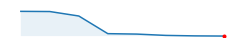

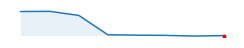

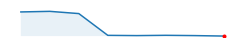

In [871]:
rb2cTop10[:3]['test'].map(sparkline)

A more informative display gain show whether the gapt time at each split / waypoint is positive or negative by using different colour fills above and below a gap of zero seconds. We can also interpolate values to remove gaps appearing in the line when the sign of the value at one way point is different to the sign of the gap at the previous waypoint.

Because the sign of the gap is indicated, we don't need to identify it with the sign colour marker at the end of the line.

In [872]:
import scipy

def sparkline2(data, figsize=(2, 0.5), colband=(('red','green'),('red','green')),
               dot=False, typ='line', **kwargs):
    """
    Returns a HTML image tag containing a base64 encoded sparkline style plot
    """
    #data = [0 if pd.isnull(d) else d for d in data]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwargs)
    
    if typ=='bar':
        color=[ colband[0][0] if c<0 else colband[0][1] for c in data  ]
        ax.bar(range(len(data)),data, color=color, width=0.8)
    else:
        #Default is line plot
        ax.plot(data, linewidth=0.0)
    
        d = scipy.zeros(len(data))

        #If we don't interpolate, we get a gap in the sections/waypoints
        #  where times change sign compared to the previous section/waypoint
        ax.fill_between(range(len(data)), data, where=data<d, interpolate=True, color=colband[0][0])
        ax.fill_between(range(len(data)), data, where=data>d, interpolate=True,  color=colband[0][1])

        if dot:
            dot = colband[1][0] if data[len(data) - 1] <0 else colband[1][1]
            plt.plot(len(data) - 1, data[len(data) - 1], dot)

    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    
    return fig2inlinehtml(fig)

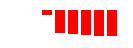

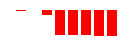

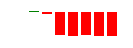

In [873]:
rb2cTop10.head(3)['test'].apply(sparkline2, typ='bar');

In [874]:
display(HTML(rb2cTop10.head(3).style.render()))

,Road Position,Crew,Brand,D01_wp1,D02_wp2,D03_wp3,D05_wp5/rav,D06_wp6,D07_wp7,D08_wp8,D09_ass,Pos,01_wp1,02_wp2,03_wp3,05_wp5/rav,06_wp6,07_wp7,08_wp8,Stage Overall,test
Bib,,,,,,,,,,,,,,,,,,,,,
304,17,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,2,19,466,2324,45,137,50,19,1,2,21,487,2324,2369,2506,2556,2575,"[-2.0, -21.0, -487.0, -2324.0, -2369.0, -2506.0, -2556.000000000002, -2575.0]"
301,11,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,38,-17,393,2286,36,25,66,-44,2,38,21,414,2286,2322,2347,2413,2369,"[-38.0, -21.0, -414.0, -2286.0, -2322.0, -2347.0, -2413.000000000002, -2369.0]"
303,13,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,-35,-46,176,1812,19,-22,22,37,3,-35,-81,95,1812,1831,1809,1831,1868,"[35.0, 81.0, -95.0, -1812.0, -1831.0, -1809.0, -1831.0000000000018, -1867.9999999999982]"


In [875]:
%%capture
brandcol = rb2cTop10.columns.get_loc("Brand")
rb2cTop10.insert(brandcol+1, 'Stage Gap', rb2cTop10['test'].apply(sparkline2,typ='bar'))
rb2cTop10.drop('test', axis=1, inplace=True)

In [876]:
display(HTML(rb2cTop10.head(3).style.render()))

,Road Position,Crew,Brand,Stage Gap,D01_wp1,D02_wp2,D03_wp3,D05_wp5/rav,D06_wp6,D07_wp7,D08_wp8,D09_ass,Pos,01_wp1,02_wp2,03_wp3,05_wp5/rav,06_wp6,07_wp7,08_wp8,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,,,
304,17,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,,2,19,466,2324,45,137,50,19,1,2,21,487,2324,2369,2506,2556,2575
301,11,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,,38,-17,393,2286,36,25,66,-44,2,38,21,414,2286,2322,2347,2413,2369
303,13,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,,-35,-46,176,1812,19,-22,22,37,3,-35,-81,95,1812,1831,1809,1831,1868


## Additional Sparklines

A couple more sparkline charts:

- rank across splits;
- gap to leader.

In [877]:
# get gap to leader at each split
tmp = get_timing_data(STAGE,vtype=VTYPE, timerank='gap', kind='full')[TIME].set_index('Bib')
tmp.head()

,Pos,Refuel,Crew,Brand,00_dss,01_wp1,02_wp2,03_wp3,04_wp4,05_wp5/rav,...,wp6_pos_06,wp6_raw_06,wp7_gain_07,wp7_pos_07,wp7_raw_07,wp8_gain_08,wp8_pos_08,wp8_raw_08,ass_gain_09,ass_raw_09
Bib,,,,,,,,,,,,,,,,,,,,,
304,1.0,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,08:56:00,00:00:36,00:00:00,00:00:00,NaT,00:00:00,...,1.0,00:00:00,=,1.0,00:00:00,=,1.0,00:00:00,=,00:00:00
301,2.0,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,08:44:00,00:00:00,00:00:00,00:01:13,NaT,00:00:38,...,2.0,00:00:47,=,2.0,00:02:39,=,2.0,00:02:23,=,00:03:26
303,3.0,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,08:48:00,00:01:13,00:01:42,00:06:32,NaT,00:08:32,...,3.0,00:08:58,=,3.0,00:11:37,=,3.0,00:12:05,=,00:11:47
314,4.0,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,08:27:00,00:01:01,00:01:22,00:05:32,NaT,00:09:28,...,4.0,00:09:20,=,4.0,00:13:31,=,4.0,00:13:21,=,00:12:50
307,5.0,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,08:18:00,00:01:30,00:01:54,00:07:34,NaT,00:13:26,...,5.0,00:14:15,=,5.0,00:16:50,=,5.0,00:17:52,=,00:18:12


In [878]:
cols = [c for c in tmp.columns if c.startswith(('0','1'))]
tmp[cols]  = tmp[cols].apply(lambda x: x.dt.total_seconds())
tmp['test']= tmp[[c for c in tmp.columns if (c.startswith(('0','1')) and 'dss' not in c)]].values.tolist()
tmp['test2']= tmp[[c for c in tmp.columns if '_pos' in c]+['Pos']].values.tolist()
#Want better rank higher up
tmp['test2'] = tmp['test2'].apply(lambda x: [-y for y in x])
tmp.head()

,Pos,Refuel,Crew,Brand,00_dss,01_wp1,02_wp2,03_wp3,04_wp4,05_wp5/rav,...,wp7_gain_07,wp7_pos_07,wp7_raw_07,wp8_gain_08,wp8_pos_08,wp8_raw_08,ass_gain_09,ass_raw_09,test,test2
Bib,,,,,,,,,,,,,,,,,,,,,
304,1.0,False,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,32160.0,36.0,0.0,0.0,NaN,0.0,...,=,1.0,00:00:00,=,1.0,00:00:00,=,00:00:00,"[36.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0]","[-17.0, -3.0, -2.0, -1.0, nan, -1.0, -1.0, -1...."
301,2.0,False,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,31440.0,0.0,0.0,73.0,NaN,38.0,...,=,2.0,00:02:39,=,2.0,00:02:23,=,00:03:26,"[0.0, 0.0, 73.0, nan, 38.0, 47.0, 159.0, 143.0...","[-11.0, -1.0, -1.0, -2.0, nan, -2.0, -2.0, -2...."
303,3.0,False,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,31680.0,73.0,102.0,392.0,NaN,512.0,...,=,3.0,00:11:37,=,3.0,00:12:05,=,00:11:47,"[73.0, 102.0, 392.0, nan, 512.0, 538.0, 697.0,...","[-13.0, -9.0, -7.0, -6.0, nan, -3.0, -3.0, -3...."
314,4.0,False,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,30420.0,61.0,82.0,332.0,NaN,568.0,...,=,4.0,00:13:31,=,4.0,00:13:21,=,00:12:50,"[61.00000000000001, 82.0, 332.0, nan, 568.0, 5...","[-5.0, -7.0, -6.0, -5.0, nan, -4.0, -4.0, -4.0..."
307,5.0,False,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,29880.0,90.0,114.0,454.0,NaN,806.0,...,=,5.0,00:16:50,=,5.0,00:17:52,=,00:18:12,"[90.0, 114.0, 454.0, nan, 806.0, 855.0, 1010.0...","[-2.0, -10.0, -9.0, -7.0, nan, -5.0, -5.0, -5...."


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


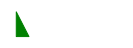

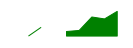

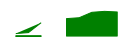

In [879]:
tmp.head(3)['test'].map(sparkline2);

In [880]:
def sparklineStep(data, figsize=(2, 0.5), **kwags):
    #data = [0 if pd.isnull(d) else d for d in data]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    
    plt.axhspan(-1, -3, facecolor='lightgrey', alpha=0.5)
    #ax.plot(range(len(data)), [-3]*len(data), linestyle=':', color='lightgrey')
    #ax.plot(range(len(data)), [-1]*len(data), linestyle=':', color='lightgrey')
    ax.plot(range(len(data)), [-10]*len(data), linestyle=':', color='lightgrey')
    ax.step(range(len(data)), data, where='mid')

    ax.set_ylim(top=-0.9)
        
    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig2inlinehtml(fig)

In [881]:
rb3c = get_timing_data(STAGE,vtype=VTYPE, timerank='gap', kind='full')[TIME].set_index('Bib')

In [882]:
def _get_col_loc(df, col=None, pos=None, left_of=None, right_of=None):
    ''' Return column position number. '''
    if col in df.columns:
        return df.columns.get_loc(col)
    elif pos and pos <len(df.columns):
        return pos
    else:
        pos = 0
    if left_of in df.columns:
        pos = df.columns.get_loc(left_of)
    elif right_of in df.columns:
        pos = min(df.columns.get_loc(right_of)+1,len(df.columns)-1)
    return pos

def moveColumn(df, col, pos=None, left_of=None, right_of=None):
    ''' Move dataframe column adjacent to a specified column. '''
    pos = _get_col_loc(df, None, pos, left_of, right_of)
    
    data = df[col].tolist()
    df.drop(col, axis=1, inplace=True)
    df.insert(pos, col, data)

def insertColumn(df, col, data, pos=None, left_of=None, right_of=None):
    ''' Insert data in dataframe column at specified location. '''
    pos =  _get_col_loc(df, col, pos, left_of, right_of)
    print(pos)
    df.insert(pos, col, data)

In [883]:
rb4cTop10.insert?


In [1008]:
%%capture
rb3cTop10 = pd.merge(rb2cTop10[[]], rb3c, how='left', left_index=True,right_index=True)

cols = [c for c in rb3cTop10.columns if c.startswith(('0','1'))]
#rb2cTop10[cols]  = rb2cTop10[cols].apply(lambda x: x.dt.total_seconds())

rb3cTop10['test2']= rb3cTop10[[c for c in rb3cTop10.columns if ('_pos' in c and 'dss' not in c)]+['Pos']].values.tolist()
#Want better rank higher up
rb3cTop10['test2'] = rb3cTop10['test2'].apply(lambda x: [-y if not pd.isnull(y) else float('NaN') for y in x ])
rb3cTop10['Waypoint Rank'] = rb3cTop10['test2'].apply(sparklineStep,figsize=(0.5, 0.5))

#rb3cTop10['test']= rb3cTop10[[c for c in rb3cTop10.columns if (c.startswith(('0','1')) and 'dss' not in c)]].values.tolist()
#rb3cTop10['test'] = rb3cTop10['test'].apply(lambda x: [-y if not pd.isnull(y) else float('NaN') for y in x ])
#rb3cTop10['Gap to Leader'] =  rb3cTop10['test'].apply(sparkline2, 
#                                                      figsize=(0.5, 0.5), 
#                                                      dot=True, 
#                                                      colband=(('pink','lightgreen'),('r.','g.')))

#Get rid of NA cols - maybe do this on a threshold?
rb3cTop10.dropna(how='all',axis=1,inplace=True)

rb3cTop10['test']= rb3cTop10[[c for c in rb3cTop10.columns if (c.startswith(('0','1')) and 'dss' not in c)]].values.tolist()
rb3cTop10['test'] = rb3cTop10['test'].apply(lambda x: [-y if not pd.isnull(y) else float('NaN') for y in x ])
rb3cTop10['Gap to Leader'] =  rb3cTop10['test'].apply(sparkline2, 
                                                      figsize=(0.5, 0.5), 
                                                      dot=True,
                                                      colband=(('pink','lightgreen'),('r.','g.')))

#rb3cTop10.drop('test', axis=1, inplace=True)
#rb3cTop10.drop('test2', axis=1, inplace=True)

#Use a copy for nw, while testing
rb4cTop10 = rb2cTop10.copy()
insertColumn(rb4cTop10, 'Gap to Leader', rb3cTop10['Gap to Leader'], right_of='Pos')
insertColumn(rb4cTop10, 'Waypoint Rank', rb3cTop10['Waypoint Rank'], right_of='Brand')

#rb4cTop10 = pd.merge(rb2cTop10, rb3cTop10[['Gap to Leader','Waypoint Rank']], left_index=True,right_index=True)


In [1009]:
rb4cTop10.head(2)

,Road Position,Crew,Brand,Waypoint Rank,Stage Gap,D01_wp1,D02_wp2,D03_wp3,D05_wp5/rav,D06_wp6,...,Pos,Gap to Leader,01_wp1,02_wp2,03_wp3,05_wp5/rav,06_wp6,07_wp7,08_wp8,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,,,
304,17.0,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",2.0,19.0,466.0,2324.0,45.0,...,1.0,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",2.0,21.0,487.0,2324.0,2369.0,2506.0,2556.0,2575.0
301,11.0,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",38.0,-17.0,393.0,2286.0,36.0,...,2.0,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",38.0,21.0,414.0,2286.0,2322.0,2347.0,2413.0,2369.0


## Add in Overall Position

Bring in overall position data from end of stage and end of previous stage

In [1010]:
#Overall Position, Previous
tmp = get_ranking_data(STAGE, VTYPE,timerank='general')[RANK].head()
tmp

,Overall Position,Bib,Crew,Brand,Time,Gap,Penalty
0,1,301,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,08:34:08,00:00:00,0 days
1,2,314,Y. AL RAJHI T. GOTTSCHALK X-RAID TEAM,MINI,08:40:56,00:06:48,0 days
2,3,304,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,08:41:11,00:07:03,0 days
3,4,307,N. ROMA A. HARO BRAVO X-RAID TEAM,MINI,08:46:10,00:12:02,0 days
4,5,303,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,08:47:53,00:13:45,0 days


In [1011]:
def getCurrPrevOverallRank(stage, vtype='car', rebase=None):
    curr = get_ranking_data(stage, vtype,timerank='general')[RANK]
    curr.rename(columns={'Time':'Overall Time'}, inplace=True)
    curr['Overall Gap'] = curr['Gap'].dt.total_seconds()
    if stage>1:
        prev = get_ranking_data(stage-1, vtype,timerank='general')[RANK]
        prev.rename(columns={'Overall Position':'Previous Overall Position',
                             'Time':'Previous Time',
                             'Gap':'Previous Gap'}, inplace=True)
        prev['Previous'] = prev['Previous Gap'].dt.total_seconds()
    else:
        prev=pd.DataFrame({'Bib':curr['Bib'],'Previous Overall Position':NaN,
                           'Previous Time':pd.Timedelta(''),
                           'Previous Gap':pd.Timedelta(''), 
                           'Previous':pd.Timedelta('')})
        
    #if rebase we need to rebase prev['Previous'] and curr['Overall Gap']
    if rebase:
        #in rebaser, note the ploarity of gap
        prev['Previous'] = -rebaseTimes(prev, bib=rebase, col='Previous Gap')
        prev['Previous'] = prev['Previous'].dt.total_seconds()
        curr['Overall Gap'] = -rebaseTimes(curr, bib=rebase, col='Overall Gap')
    df = pd.merge(curr[['Bib','Overall Position', 'Overall Gap']],
                    prev[['Bib','Previous Overall Position','Previous Time', 'Previous']],
                    on='Bib')
    
    return df.set_index('Bib')

In [1012]:
getCurrPrevOverallRank(1, rebase=REBASER).head().dtypes

Overall Position                      int64
Overall Gap                         float64
Previous Overall Position           float64
Previous Time                datetime64[ns]
Previous                            float64
dtype: object

In [1013]:
getCurrPrevOverallRank(STAGE, VTYPE, rebase=REBASER).head()

,Overall Position,Overall Gap,Previous Overall Position,Previous Time,Previous
Bib,,,,,
301,1,2279.0,8,04:36:11,-90.0
314,2,1871.0,4,04:33:35,66.0
304,3,1856.0,13,04:46:40,-719.0
307,4,1557.0,3,04:33:27,74.0
303,5,1454.0,12,04:41:35,-414.0


In [1014]:
rb4cTop10 = pd.merge(rb4cTop10,
                     getCurrPrevOverallRank(STAGE, VTYPE, rebase=REBASER)[['Overall Position',
                                                                            'Previous Overall Position',
                                                                           'Overall Gap', 'Previous']],
                     left_index=True, right_index=True)
moveColumn(rb4cTop10, 'Previous', left_of='Crew')
moveColumn(rb4cTop10, 'Previous Overall Position', left_of='Previous')
moveColumn(rb4cTop10, 'Overall Position', right_of='Pos')
moveColumn(rb4cTop10, 'Overall Gap', left_of='Pos')
rb4cTop10.head(3)

,Road Position,Previous Overall Position,Previous,Crew,Brand,Waypoint Rank,Stage Gap,D01_wp1,D02_wp2,D03_wp3,...,Overall Position,Gap to Leader,01_wp1,02_wp2,03_wp3,05_wp5/rav,06_wp6,07_wp7,08_wp8,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,,,
304,17.0,13,-719.0,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",2.0,19.0,466.0,...,3,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",2.0,21.0,487.0,2324.0,2369.0,2506.0,2556.0,2575.0
301,11.0,8,-90.0,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",38.0,-17.0,393.0,...,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",38.0,21.0,414.0,2286.0,2322.0,2347.0,2413.0,2369.0
303,13.0,12,-414.0,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-35.0,-46.0,176.0,...,5,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-35.0,-81.0,95.0,1812.0,1831.0,1809.0,1831.0,1868.0


In [1015]:
rb4cTop10.columns

Index(['Road Position', 'Previous Overall Position', 'Previous', 'Crew',
       'Brand', 'Waypoint Rank', 'Stage Gap', 'D01_wp1', 'D02_wp2', 'D03_wp3',
       'D05_wp5/rav', 'D06_wp6', 'D07_wp7', 'D08_wp8', 'D09_ass',
       'Overall Gap', 'Pos', 'Overall Position', 'Gap to Leader', '01_wp1',
       '02_wp2', '03_wp3', '05_wp5/rav', '06_wp6', '07_wp7', '08_wp8',
       'Stage Overall'],
      dtype='object')

## Table Image Grabber

One way of capturing the table output is to render the HTML page in a browser and then grab a screenshot of the contents of the browser window.

The `selenium` web testing framework can help us achieve this.

The code below is taken from my WRC notebooks, so there is less commentary about what the pieces are and how they fit together than there might otherwise be...

Changes to outputter - comment out set_window_size to allow browser to get full table, full table grabber

In [1016]:
import os
import time
from selenium import webdriver

#Via https://stackoverflow.com/a/52572919/454773
def setup_screenshot(driver,path):
    # Ref: https://stackoverflow.com/a/52572919/
    original_size = driver.get_window_size()
    required_width = driver.execute_script('return document.body.parentNode.scrollWidth')
    required_height = driver.execute_script('return document.body.parentNode.scrollHeight')
    driver.set_window_size(required_width, required_height)
    # driver.save_screenshot(path)  # has scrollbar
    driver.find_element_by_tag_name('body').screenshot(path)  # avoids scrollbar
    driver.set_window_size(original_size['width'], original_size['height'])
    

def getTableImage(url, fn='dummy_table', basepath='.', path='.', delay=5, height=420, width=800):
    ''' Render HTML file in browser and grab a screenshot. '''
    browser = webdriver.Chrome()
    #browser.set_window_size(width, height)
    browser.get(url)
    #Give the map tiles some time to load
    time.sleep(delay)
    imgpath='{}/{}.png'.format(path,fn)
    imgfn = '{}/{}'.format(basepath, imgpath)
    imgfile = '{}/{}'.format(os.getcwd(),imgfn)
    
    setup_screenshot(browser,imgfile)
    browser.quit()
    os.remove(imgfile.replace('.png','.html'))
    #print(imgfn)
    return imgpath


def getTablePNG(tablehtml,basepath='.', path='testpng', fnstub='testhtml'):
    ''' Save HTML table as file. '''
    if not os.path.exists(path):
        os.makedirs('{}/{}'.format(basepath, path))
    fn='{cwd}/{basepath}/{path}/{fn}.html'.format(cwd=os.getcwd(), basepath=basepath, path=path,fn=fnstub)
    tmpurl='file://{fn}'.format(fn=fn)
    with open(fn, 'w') as out:
        out.write(tablehtml)
    return getTableImage(tmpurl, fnstub, basepath, path)

We get some nonsense in charts if there are missing values.

In [1017]:
s2 = moreStyleDriverSplitReportBaseDataframe(rb4cTop10, STAGE)
display(HTML(s2))

,Road Position,Previous Overall Position,Previous,Crew,Brand,Waypoint Rank,Stage Gap,D01_wp1,D02_wp2,D03_wp3,D05_wp5/rav,D06_wp6,D07_wp7,D08_wp8,D09_ass,Overall Gap,Pos,Overall Position,Gap to Leader,01_wp1,02_wp2,03_wp3,05_wp5/rav,06_wp6,07_wp7,08_wp8,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,,,,,,,,,
304,17,13,-719,S. PETERHANSEL D. CASTERA X-RAID MINI JCW TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAUJJREFUWIXtl71KA0EQgL%2BITa6wUEJAK5so2tj5BnZi5fOIL2DrG1gJInapbEUQERSSYoSgwnKEy49s4C7JWkgCMRdHD2NS7NfNsOx%2BzM4uuznnnGOOWJi1wFe8kMbiTwee3dS4vH8dxlurSxztb3N89cjTWyvT4oM5VCFjzFju/PaZatihVMgDYK3FGIO1liSJMwlZa8dyubRTZozh4iGkXKkPcwOZ08PNTItPolgsjsQTe6hcqVMNO8O4VMizt7HypzJpfNtD06iIRmqFTq5r3L28/6vIgNQKBUHA7voyBztrY3s8bVKbepbM3cXohTS8kIYX0vBCGl5IwwtpeCENL6QxUUhEiKIIAOccIkKj0QCg3%2B8jIjSbTQB6vd5I3O12ERFarc8PZJIkiAjtdhuAOI4Rkd8JzQr/ptbwQhpzJ/QB8b2BHYn81A0AAAAASUVORK5CYII%3D"" />",,2,19,466,2324,45,137,50,19,1856,1,3,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAXZJREFUWIXtmDFqwzAUQJ/sWHHSTIF2K%2BQKHUMXQ%2B7Ri/QAuUfvETB08AE6FkoghS5dSkugAlkdnNA6OP4eVMVD3mRLAj2%2B9PUtK%2Beco0dEpxY45CwkcTKhYlOwfFxSbIpa%2B6BxtLXw9g5/9/vVFIbam8ziYYGxBh1rtvdbQehrCy%2BvwF5IQarhcupFKF/nGGuwzmKsqfUdX7JIVT5u9zxKvcgAZLMMHWtiFaPjetSbI3RIWcJo6E1ofj1ndbciX%2Bdks6zWpxoPxo9PeHoGW1bvgxhub7wJtdEty1I/m7kL3YTGo3/W%2BEUWUgom4wAqFbKQ5wwTp%2Bs0auwvwyRkIVtC2iehZABRuJInzxQwOtBFaBIu5UESihRchEt5kISU8lrDutAu5Ah6BoEoVAatY9AmZEtIkmrZAtIeocD7ByShgEV1T7tQwM%2BOPYJQ35YscMqDdOvQSUCV3bSNrWr3URY45eHYrcM5%2BDbBK/1xoRNy/vsh0TuhHwfkUrpYau5sAAAAAElFTkSuQmCC"" />",2,21,487,2324,2369,2506,2556,2575
301,11,8,-90,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING SA,TOYOTA,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAARRJREFUWIXt1z9KxEAUgPFvRRC3lZBCWGxWWxuxFQRbS8Eb2HoDSxsvYukFvIQiK7zCQghB8g%2ByMJNkLKyyG3juoibC/Lo8CPl4YSAZOeccA7LRd8AiH6TZ7BrePDzx/J4vzc8Pd7k8nvx9UFmWWGtas1k8x1rD6d7WjwaEYdi6HnWdsiiKlm68un9hFs/ZD7YBmAZjrk8m3D2%2B8RqXa8VMgzG3F0etWeeGupwd7AAfaz14Fd/e0G9ZfGWDO2WdG%2BrT4DbkgzQ%2BSOODND5I44M0PkjjgzQ%2BSPN/gkSEJEkAcM4hIqRpCkDTNIgIWZYBUNd167qqKkSEPP/62bTWIiIURQGAMQYRWS2oL/4jX%2BODNIML%2BgTR6G65RpqZJgAAAABJRU5ErkJggg%3D%3D"" />",,38,-17,393,2286,36,25,66,-44,2279,2,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAcVJREFUWIXtmLlOw0AQhr/1gmMTSOLcQAAFIQQCQYOQ0uVJKXgSKo4aHgAKRMmpFImUpdgI4pDDdryxC37JsuTZsT/NjGfWFkopRYpkJQ0wqn%2BgWUod0FKgVZ8dePuI/%2BmWBRsVECIk0Os7PD7HD4SAYh7czM%2BVYCmrl7WzIt7DEowqGJC9DKV8oKXzKnhRN%2Bo654YV/Am5LNgTSk7GBxr8TkLA1pgoSQkHTdis6tSOqQszQAC10oi3BSf7UPZgbxtap4MXYFFAUkK1OPAUcNjUqRxWqTBXCsN7Nmr6vLOhIzOq/Br0o28ggjXGYWVdODuCFWe8XVp6zVcnElC02GZdX7v/o4o33R470Cx5uchvmxmg1ZXIrmaAhNDFHUHmZkG5EGnUmAPycuiRHk7mgJwMLIXvKmbHd3FoyyKEPmak0SxQqTCAEHoOnh/P7E/hYxpG3poeNeuV323qdh2eXqDfH%2BtiNkJSwm7Dt2dmszrVZfGfQVLqqE3o5Ml8lzVq8HAPlxdwd%2Bu3qSR0fa2U4yhlWUq5rs%2BUTISurqDX04Xd7fpMyQC122Dbup5s22cSif0furnRkWq3odVKAdAEpe7vR%2BqAvgF4ONLn14JwCwAAAABJRU5ErkJggg%3D%3D"" />",38,21,414,2286,2322,2347,2413,2369
303,13,12,-414,J. PRZYGONSKI T. COLSOUL ORLEN X-RAID TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAT9JREFUWIXtlr9Kw1AUh7%2BKXTJkEKREJweXuLiJDyGOPoKPIY4uPobgWPoCrt262EU4QqGUotgkBYc2yXUQhFxL0pQ2uYH7befChY/zO/dPSymlMIi9ug

In [993]:
getTablePNG(s2)

'testpng/testhtml.png'

In [199]:
!pwd

/Users/tonyhirst/Documents/GitHub/WRC_sketches/doodles


## Grab data over several stages

In [ ]:
##sketch - data grab

#Create a dataframe of stage times over several stages
rallydata = pd.DataFrame()

for stage in [1,2,3,4,5, 6]:
    _data = _get_timing( _get_data(stage), TIME)[TIME]
    _timing_data_long = _timing_long(_data)
    _timing_data_long.insert(0,'stage', stage)
    rallydata = pd.concat([rallydata, _timing_data_long], sort=False)